In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import pycountry_convert as pc
import folium 
from datetime import datetime
from datetime import timedelta


import matplotlib.pyplot as plt
plt.style.use('seaborn-white') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import matplotlib.dates as mdate
pio.templates.default = "plotly_dark"

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.manual_seed(0)
np.random.seed(0)
# torch.cuda.set_device(3)



In [3]:
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [75]:
# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 50 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
          
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.05):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def _log2(data):
    return np.exp(np.exp(data))
    
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw, ganData = None):
    inout_seq = []
    inout_seq.extend(create_inout_sequences_front(input_data, tw))
    inout_seq.extend(create_inout_sequences_back(input_data, tw))
    if ganData is not None:
        inout_seq.extend(create_train_sequences(ganData, tw))
    return torch.FloatTensor(inout_seq)

def create_train_sequences(input_data, tw):
    inout_seq = []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        train_seq = input_data[i][0:tw]
        train_label = input_data[i][1:tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    
def create_inout_sequences_front(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def create_inout_sequences_back(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(tw, L, 1):
        train_seq = input_data[i - tw : i ]
        train_label = input_data[i - tw + output_window : i + output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def addCsv(df): #累加
    temp_df = df.copy()
#  ->   2021/4/29新加入代码
#     temp_df = temp_df[temp_df["confirmed"] >= 1]
#     temp_df = temp_df[temp_df["fatalities"] >= 1]
#  <-  2021/4/29新加入代码
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, truthName, ganName = None):
        self.scaler = StandardScaler()  #'/home/soul/NewWorkSpace/Informer2020CP/data/ETT/global.csv'
        self.amplitude = pd.read_csv(truthName)
        self.amplitude = addCsv(self.amplitude)  ## 处理累加
        self.amplitude =  np.array(self.amplitude['confirmed'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        #         _del30_confirmed_SJ_noise_61_1000
        #/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_del30_confirmed_noise_61_1000.npy
        if ganName is not None:
            self.trainData = np.load(ganName)
        else:
            self.trainData = None
        
    def trainTestData(self):
        train_sampels = -30
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]

        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        test_sequenc = create_inout_sequences(test_data, input_window)
        
        return train_sequence.to(device),test_sequenc.to(device)
    
    def train_data(self):
        train_sequence = create_train_sequences(self.trainData, input_window, self.trainData)
        return train_sequence.to(device)
    
    def trainPredictData(self):
        self.trainData = np.load("/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_confirmed_noise_61_1000.npy")
        train_data = self.amplitude
        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        return train_sequence.to(device)
    
    def get_plot_data(self, eval_model):
        eval_model.eval() 
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse   = error_mse(truth[-30:], test_result[-30:])
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
            mae   = error_mae(truth[-30:], test_result[-30:])
            mape  = error_mape(truth[-30:].numpy(), test_result[-30:].numpy())
            rmse  = error_rmse(truth[-30:], test_result[-30:])
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        return mse, rmsle, mae, mape, rmse, truth, test_result
    
    def plot_and_loss(self, eval_model,epoch, test = False):
        eval_model.eval() 
        total_loss = 0.
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse = criterion(truth[-30:], test_result[-30:]).cpu().item() 
            rmsle = error_rmsle(truth[-30:], test_result[-30:])
        
            if test == False:
                temp_truth = truth
                for t in range(0, 30):
                    data = np.array(temp_truth[-input_window:]).reshape([input_window, 1, 1]).astype(np.float32)
                    output = eval_model(torch.FloatTensor(data).to(device))   
                    temp_truth = torch.cat((temp_truth, output[-1].view(-1).cpu()), 0)
                    test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        
        fig = pyplot.figure(figsize=[20, 10])
        pyplot.title('Global Confirmed Data')
        pyplot.plot(truth[-100:], color='blue', marker='o')
        pyplot.plot(truth[-100:],color="blue", label = 'Measured')
        
        if test == False:
            pyplot.plot(test_result[-130:], color='green', marker='o')
            pyplot.plot(test_result[-130:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-130:-30], color='red', marker='o')
            pyplot.plot(test_result[-130:-30], color="red", label = 'Predicted')        
        else:
            pyplot.plot(test_result[-100:], color='green', marker='o')
            pyplot.plot(test_result[-100:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-100:-30], color='red', marker='o')
            pyplot.plot(test_result[-100:-30], color="red", label = 'Predicted')
        pyplot.show()
        pyplot.close()
        
        
        pyplot.title('Global Confirmed Data')
        pyplot.plot(test_result,color="green", label = 'Predicted')
        pyplot.plot(test_result[:-30],color="red", label = 'Predicted')
        pyplot.plot(truth,color="blue", label = 'Measured')
        pyplot.grid(True)
        pyplot.legend(loc='best')
    #     pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
        pyplot.show()
        pyplot.close()
        
        return mse, rmsle


def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - i) #len(source) - 1 - i
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    a = output_window / input_window
    b = 1 - a
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
#         loss = criterion(output, targets)
        loss = criterion(output[-output_window:], targets[-output_window:])
#         loss =  a * criterion(output[:-output_window], targets[:-output_window]) + b * criterion(output[-output_window:], targets[-output_window:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 10
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)


def saveModel(model, name):
    # 保存
    torch.save(model.state_dict(), './saveModel/' + name + '.pkl')

def loadModel(model, name):
    # 加载
    model.load_state_dict(torch.load('./saveModel/' + name + '.pkl', map_location='cuda:0'))
    return model


def save_epoch_data(epochs = 20):
    df = pd.DataFrame()
    df['X'] = []
    df['Y'] = []
    
    frames = []
    for i in range(epochs):
        model = TransAm().to(device)
        model = loadModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best")
        dealData = DealData()
        truths, predicts = dealData.get_plot_data(model)
    
        temp_df = pd.DataFrame()
        temp_df['X'] = range(len(predicts))
        temp_df['Y'] = predicts
        
        frames.append(temp_df)
        
    result = pd.concat(frames)
    result.to_csv("epoch_data_changLoss_noise_20.csv")

    
def plog_epoch_image(epochs = 20):
    
    df = pd.read_csv("epoch_data_changLoss_noise_20.csv")

    sns.lineplot(x="X", y="Y",color="red", ci="sd", data=df)
    
#     plt.plot(serise, truth[-100:], color='purple', marker='o')
#     plt.plot(serise, truth[-100:],color="purple", label = 'Reported')

#     plt.plot(serise, predict[-100:], color='orange', marker='o')
#     plt.plot(serise, predict[-100:], color="orange", label = 'Projection')

#     plt.plot(serise, predict[-100:-30], color='crimson', marker='o')
#     plt.plot(serise, predict[-100:-30], color="crimson", label = 'Fitting')

def plot_image(truth, predict, start = '2020-01-22', end = '2021-04-25', title = 'Global Confirmed Data', isSave = False):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    serise= pd.date_range(start, end)
    plt.xticks(pd.date_range(start, end, freq='30d'),rotation=45)
    plt.title(title)
    
    plt.plot(serise, truth,color="purple", linewidth=4.0, label = 'Reported')
    plt.plot(serise, predict, color="orange", linewidth=4.0, label = 'Projection')
    plt.plot(serise[:-30], predict[:-30], linewidth=4.0, color="crimson", label = 'Fitting')
    plt.grid(True, which='both')
    plt.legend(loc="best")
    
    if isSave == True:
        plt.savefig('./saveImage/confirmed/' + title)
    plt.show()


In [49]:
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/us.csv")
df

,Unnamed: 0,country,date,confirmed,fatalities,population_density,median_age,aged_65_older,aged_70_older,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share,r_population
0,38,US,2020-02-29,8.0,1.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
1,39,US,2020-03-01,7.0,0.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
2,40,US,2020-03-02,23.0,5.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
3,41,US,2020-03-03,19.0,1.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
4,42,US,2020-03-04,33.0,4.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,455,US,2021-04-21,62857.0,842.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
418,456,US,2021-04-22,67257.0,943.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
419,457,US,2021-04-23,62399.0,852.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0
420,458,US,2021-04-24,53363.0,724.0,35.608,38.3,15.413,9.732,0.229877,0.153646,0.142621,0.001367,0.558557,1.0,0.257143,0.791667,0.83,0.230103,330610570.0


In [71]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/Russia.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_russia_del30_confirmed_noise_1000.npy")
train_data, val_data = dealData.trainTestData()
print(train_data.shape, val_data.shape) 

torch.Size([1662, 2, 50]) torch.Size([60, 2, 50])


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     1/    6 batches | lr 0.005000 | 61.24 ms | loss 140.80297 | ppl 14123842869216914184124844121885181812930626674226895163228160.00
| epoch   1 |     2/    6 batches | lr 0.005000 | 25.46 ms | loss 9.45395 | ppl 12758.51
| epoch   1 |     3/    6 batches | lr 0.005000 | 39.58 ms | loss 37.67664 | ppl 23054638293234684.00
| epoch   1 |     4/    6 batches | lr 0.005000 | 38.32 ms | loss 13.55208 | ppl 768411.10
| epoch   1 |     5/    6 batches | lr 0.005000 | 25.05 ms | loss 15.45546 | ppl 5154901.88
| epoch   1 |     6/    6 batches | lr 0.005000 | 23.86 ms | loss 3.38543 | ppl    29.53
| epoch   2 |     1/    6 batches | lr 0.004513 | 54.72 ms | loss 43.42653 | ppl 7242695487944036352.00
| epoch   2 |     2/    6 batches | lr 0.004513 | 25.97 ms | loss 8.71679 | ppl  6104.56
| epoch   2 |     3/    6 batches | lr 0.004513 | 25.40 ms | loss 11.18516 | ppl 72053.24
| epoch   2 |     4/    6 batches | lr 0.004513 | 26.80 ms | loss 6.65481 | ppl   776.51
| epoch   2 |    

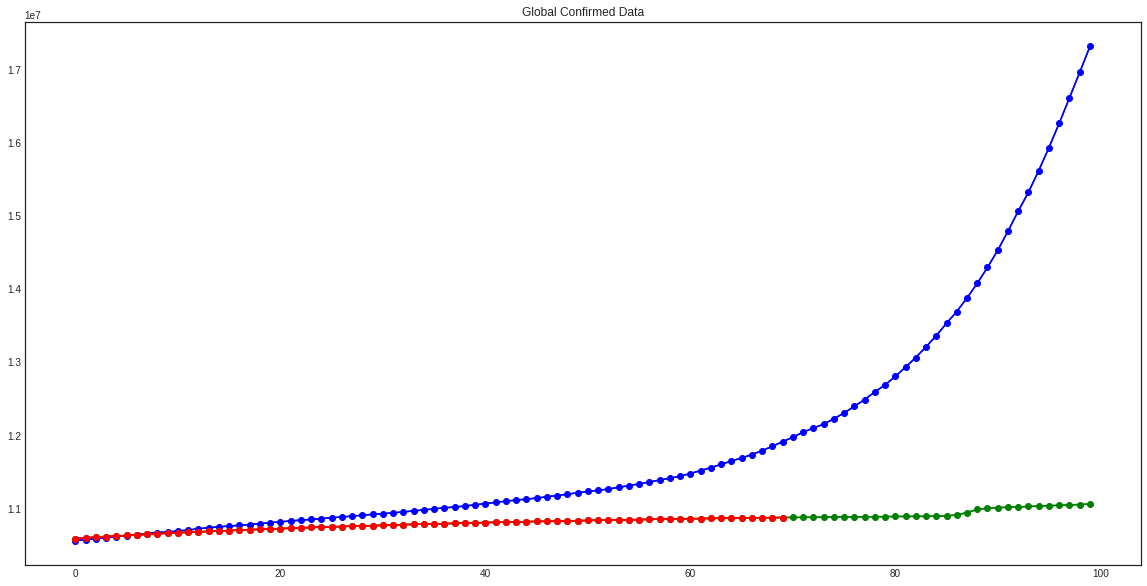

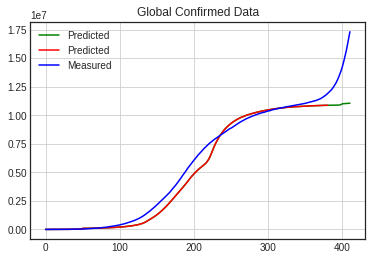

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  2.86s | mse loss 0.45509 | rmsle loss 0.27564 
-----------------------------------------------------------------------------------------
| epoch  11 |     1/    6 batches | lr 0.002844 | 49.38 ms | loss 0.02903 | ppl     1.03
| epoch  11 |     2/    6 batches | lr 0.002844 | 25.75 ms | loss 0.00361 | ppl     1.00
| epoch  11 |     3/    6 batches | lr 0.002844 | 26.40 ms | loss 0.10954 | ppl     1.12
| epoch  11 |     4/    6 batches | lr 0.002844 | 26.35 ms | loss 0.07211 | ppl     1.07
| epoch  11 |     5/    6 batches | lr 0.002844 | 24.90 ms | loss 0.00907 | ppl     1.01
| epoch  11 |     6/    6 batches | lr 0.002844 | 23.57 ms | loss 0.02822 | ppl     1.03


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  12 |     1/    6 batches | lr 0.002702 | 50.78 ms | loss 0.03884 | ppl     1.04
| epoch  12 |     2/    6 batches | lr 0.002702 | 27.36 ms | loss 0.01613 | ppl     1.02
| epoch  12 |     3/    6 batches | lr 0.002702 | 25.13 ms | loss 0.01402 | ppl     1.01
| epoch  12 |     4/    6 batches | lr 0.002702 | 24.25 ms | loss 0.01123 | ppl     1.01
| epoch  12 |     5/    6 batches | lr 0.002702 | 25.02 ms | loss 0.09913 | ppl     1.10
| epoch  12 |     6/    6 batches | lr 0.002702 | 23.45 ms | loss 0.06938 | ppl     1.07
| epoch  13 |     1/    6 batches | lr 0.002567 | 50.15 ms | loss 0.13500 | ppl     1.14
| epoch  13 |     2/    6 batches | lr 0.002567 | 36.84 ms | loss 0.02133 | ppl     1.02
| epoch  13 |     3/    6 batches | lr 0.002567 | 25.24 ms | loss 0.01852 | ppl     1.02
| epoch  13 |     4/    6 batches | lr 0.002567 | 34.17 ms | loss 0.03904 | ppl     1.04
| epoch  13 |     5/    6 batches | lr 0.002567 | 24.89 ms | loss 0.02659 | ppl     1.03
| epoch  13 |     6/ 

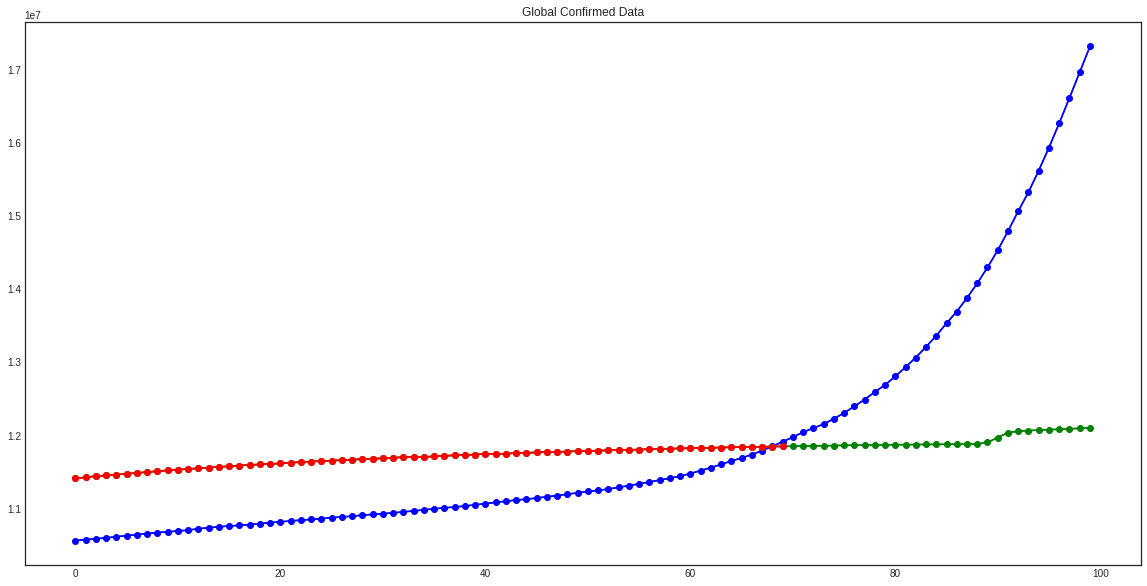

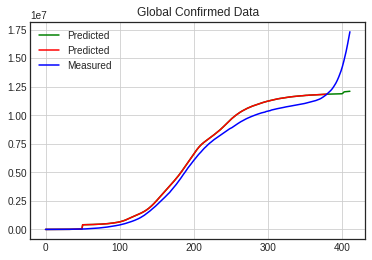

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  2.81s | mse loss 0.25128 | rmsle loss 0.19231 
-----------------------------------------------------------------------------------------
| epoch  21 |     1/    6 batches | lr 0.001703 | 50.11 ms | loss 0.03247 | ppl     1.03
| epoch  21 |     2/    6 batches | lr 0.001703 | 30.04 ms | loss 0.05859 | ppl     1.06
| epoch  21 |     3/    6 batches | lr 0.001703 | 25.08 ms | loss 0.00724 | ppl     1.01
| epoch  21 |     4/    6 batches | lr 0.001703 | 30.09 ms | loss 0.00476 | ppl     1.00
| epoch  21 |     5/    6 batches | lr 0.001703 | 29.49 ms | loss 0.00276 | ppl     1.00
| epoch  21 |     6/    6 batches | lr 0.001703 | 23.78 ms | loss 0.01970 | ppl     1.02


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  22 |     1/    6 batches | lr 0.001618 | 59.29 ms | loss 0.02062 | ppl     1.02
| epoch  22 |     2/    6 batches | lr 0.001618 | 28.50 ms | loss 0.01297 | ppl     1.01
| epoch  22 |     3/    6 batches | lr 0.001618 | 25.89 ms | loss 0.03600 | ppl     1.04
| epoch  22 |     4/    6 batches | lr 0.001618 | 24.92 ms | loss 0.03267 | ppl     1.03
| epoch  22 |     5/    6 batches | lr 0.001618 | 29.38 ms | loss 0.00589 | ppl     1.01
| epoch  22 |     6/    6 batches | lr 0.001618 | 23.30 ms | loss 0.00419 | ppl     1.00
| epoch  23 |     1/    6 batches | lr 0.001537 | 56.63 ms | loss 0.00794 | ppl     1.01
| epoch  23 |     2/    6 batches | lr 0.001537 | 31.60 ms | loss 0.00187 | ppl     1.00
| epoch  23 |     3/    6 batches | lr 0.001537 | 24.98 ms | loss 0.03622 | ppl     1.04
| epoch  23 |     4/    6 batches | lr 0.001537 | 25.08 ms | loss 0.05672 | ppl     1.06
| epoch  23 |     5/    6 batches | lr 0.001537 | 31.09 ms | loss 0.00555 | ppl     1.01
| epoch  23 |     6/ 

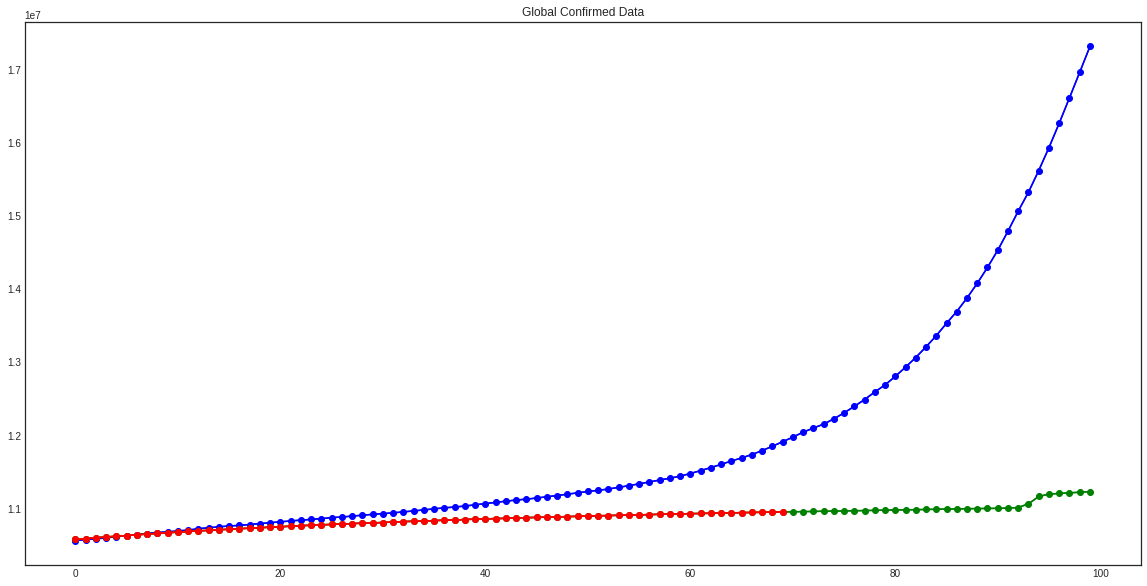

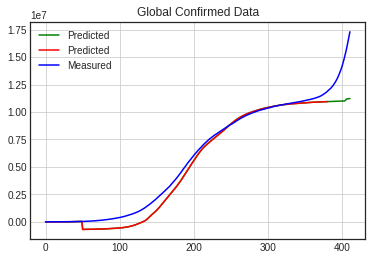

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  2.86s | mse loss 0.43300 | rmsle loss 0.26752 
-----------------------------------------------------------------------------------------
| epoch  31 |     1/    6 batches | lr 0.001020 | 50.22 ms | loss 0.04392 | ppl     1.04
| epoch  31 |     2/    6 batches | lr 0.001020 | 24.27 ms | loss 0.00222 | ppl     1.00
| epoch  31 |     3/    6 batches | lr 0.001020 | 25.10 ms | loss 0.01221 | ppl     1.01
| epoch  31 |     4/    6 batches | lr 0.001020 | 25.17 ms | loss 0.00485 | ppl     1.00
| epoch  31 |     5/    6 batches | lr 0.001020 | 25.09 ms | loss 0.01243 | ppl     1.01
| epoch  31 |     6/    6 batches | lr 0.001020 | 23.60 ms | loss 0.00954 | ppl     1.01


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  32 |     1/    6 batches | lr 0.000969 | 53.17 ms | loss 0.03568 | ppl     1.04
| epoch  32 |     2/    6 batches | lr 0.000969 | 25.23 ms | loss 0.00165 | ppl     1.00
| epoch  32 |     3/    6 batches | lr 0.000969 | 24.85 ms | loss 0.01854 | ppl     1.02
| epoch  32 |     4/    6 batches | lr 0.000969 | 34.98 ms | loss 0.00414 | ppl     1.00
| epoch  32 |     5/    6 batches | lr 0.000969 | 24.88 ms | loss 0.01637 | ppl     1.02
| epoch  32 |     6/    6 batches | lr 0.000969 | 23.44 ms | loss 0.03786 | ppl     1.04
| epoch  33 |     1/    6 batches | lr 0.000920 | 50.28 ms | loss 0.01239 | ppl     1.01
| epoch  33 |     2/    6 batches | lr 0.000920 | 30.02 ms | loss 0.00456 | ppl     1.00
| epoch  33 |     3/    6 batches | lr 0.000920 | 24.21 ms | loss 0.00317 | ppl     1.00
| epoch  33 |     4/    6 batches | lr 0.000920 | 25.04 ms | loss 0.00477 | ppl     1.00
| epoch  33 |     5/    6 batches | lr 0.000920 | 32.04 ms | loss 0.01565 | ppl     1.02
| epoch  33 |     6/ 

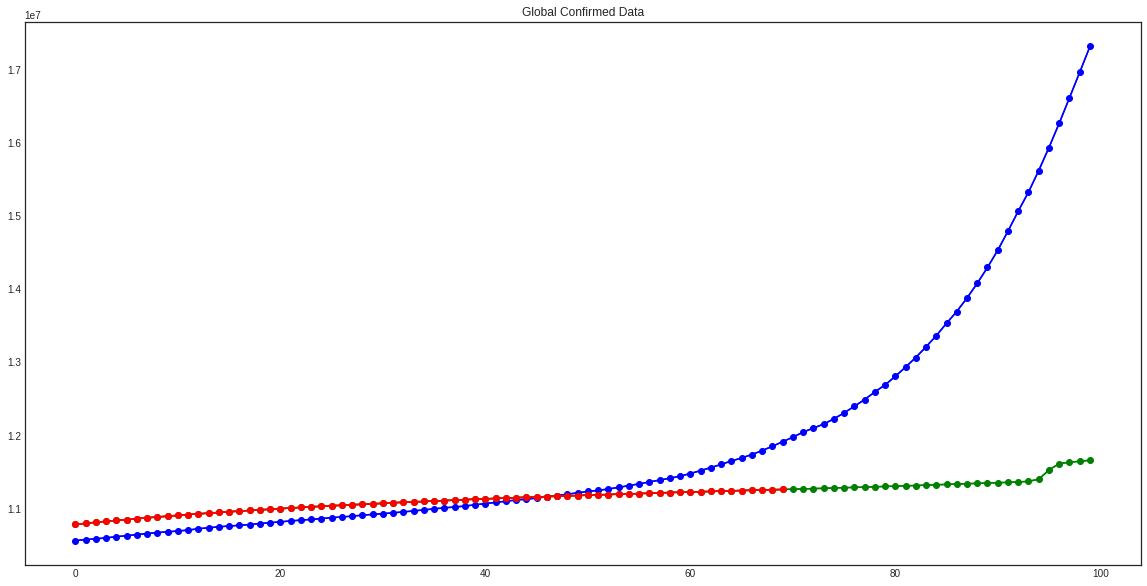

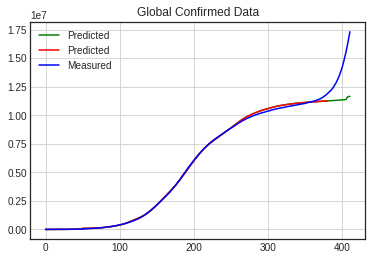

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  2.75s | mse loss 0.35457 | rmsle loss 0.23691 
-----------------------------------------------------------------------------------------
| epoch  41 |     1/    6 batches | lr 0.000610 | 50.58 ms | loss 0.00435 | ppl     1.00
| epoch  41 |     2/    6 batches | lr 0.000610 | 34.84 ms | loss 0.00357 | ppl     1.00
| epoch  41 |     3/    6 batches | lr 0.000610 | 27.75 ms | loss 0.00609 | ppl     1.01
| epoch  41 |     4/    6 batches | lr 0.000610 | 25.20 ms | loss 0.00109 | ppl     1.00
| epoch  41 |     5/    6 batches | lr 0.000610 | 33.84 ms | loss 0.00184 | ppl     1.00
| epoch  41 |     6/    6 batches | lr 0.000610 | 23.84 ms | loss 0.00448 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  42 |     1/    6 batches | lr 0.000580 | 51.83 ms | loss 0.00402 | ppl     1.00
| epoch  42 |     2/    6 batches | lr 0.000580 | 25.88 ms | loss 0.00260 | ppl     1.00
| epoch  42 |     3/    6 batches | lr 0.000580 | 25.05 ms | loss 0.00572 | ppl     1.01
| epoch  42 |     4/    6 batches | lr 0.000580 | 25.21 ms | loss 0.00344 | ppl     1.00
| epoch  42 |     5/    6 batches | lr 0.000580 | 24.23 ms | loss 0.00098 | ppl     1.00
| epoch  42 |     6/    6 batches | lr 0.000580 | 23.80 ms | loss 0.00673 | ppl     1.01
| epoch  43 |     1/    6 batches | lr 0.000551 | 50.64 ms | loss 0.00271 | ppl     1.00
| epoch  43 |     2/    6 batches | lr 0.000551 | 27.69 ms | loss 0.00508 | ppl     1.01
| epoch  43 |     3/    6 batches | lr 0.000551 | 31.61 ms | loss 0.00453 | ppl     1.00
| epoch  43 |     4/    6 batches | lr 0.000551 | 24.40 ms | loss 0.00145 | ppl     1.00
| epoch  43 |     5/    6 batches | lr 0.000551 | 33.70 ms | loss 0.00159 | ppl     1.00
| epoch  43 |     6/ 

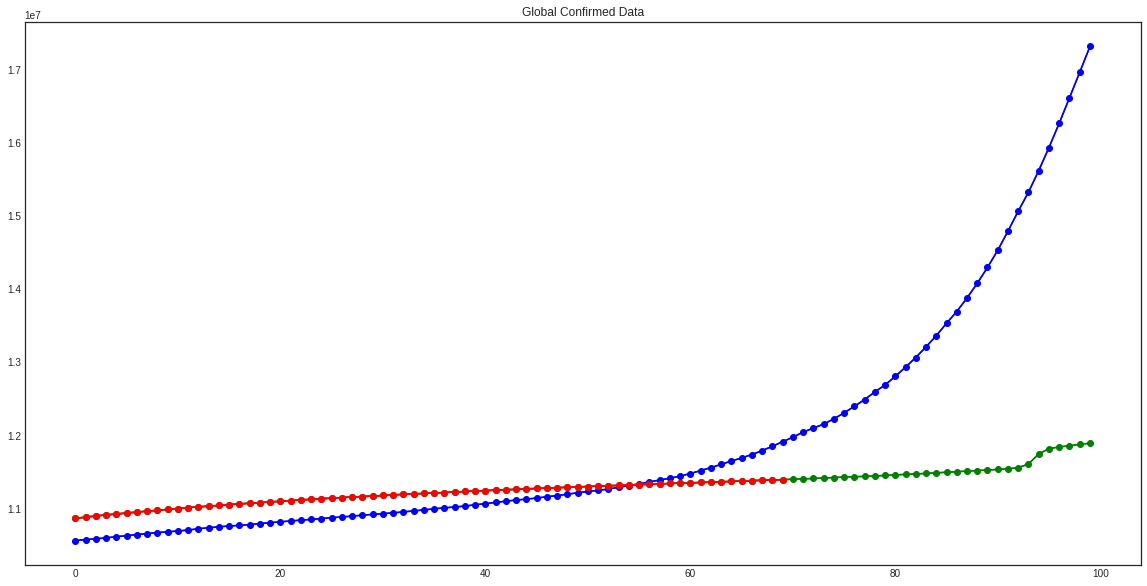

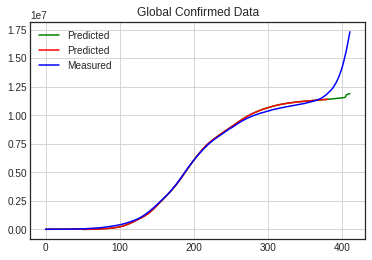

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  2.88s | mse loss 0.31311 | rmsle loss 0.21996 
-----------------------------------------------------------------------------------------
| epoch  51 |     1/    6 batches | lr 0.000365 | 60.22 ms | loss 0.00183 | ppl     1.00
| epoch  51 |     2/    6 batches | lr 0.000365 | 24.83 ms | loss 0.00304 | ppl     1.00
| epoch  51 |     3/    6 batches | lr 0.000365 | 24.06 ms | loss 0.00257 | ppl     1.00
| epoch  51 |     4/    6 batches | lr 0.000365 | 24.29 ms | loss 0.00185 | ppl     1.00
| epoch  51 |     5/    6 batches | lr 0.000365 | 24.30 ms | loss 0.00180 | ppl     1.00
| epoch  51 |     6/    6 batches | lr 0.000365 | 22.53 ms | loss 0.00293 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  52 |     1/    6 batches | lr 0.000347 | 53.31 ms | loss 0.00224 | ppl     1.00
| epoch  52 |     2/    6 batches | lr 0.000347 | 24.61 ms | loss 0.00193 | ppl     1.00
| epoch  52 |     3/    6 batches | lr 0.000347 | 29.42 ms | loss 0.00242 | ppl     1.00
| epoch  52 |     4/    6 batches | lr 0.000347 | 23.83 ms | loss 0.00104 | ppl     1.00
| epoch  52 |     5/    6 batches | lr 0.000347 | 31.38 ms | loss 0.00099 | ppl     1.00
| epoch  52 |     6/    6 batches | lr 0.000347 | 23.67 ms | loss 0.00492 | ppl     1.00
| epoch  53 |     1/    6 batches | lr 0.000330 | 48.49 ms | loss 0.00263 | ppl     1.00
| epoch  53 |     2/    6 batches | lr 0.000330 | 25.51 ms | loss 0.00250 | ppl     1.00
| epoch  53 |     3/    6 batches | lr 0.000330 | 24.12 ms | loss 0.00243 | ppl     1.00
| epoch  53 |     4/    6 batches | lr 0.000330 | 24.14 ms | loss 0.00114 | ppl     1.00
| epoch  53 |     5/    6 batches | lr 0.000330 | 24.36 ms | loss 0.00126 | ppl     1.00
| epoch  53 |     6/ 

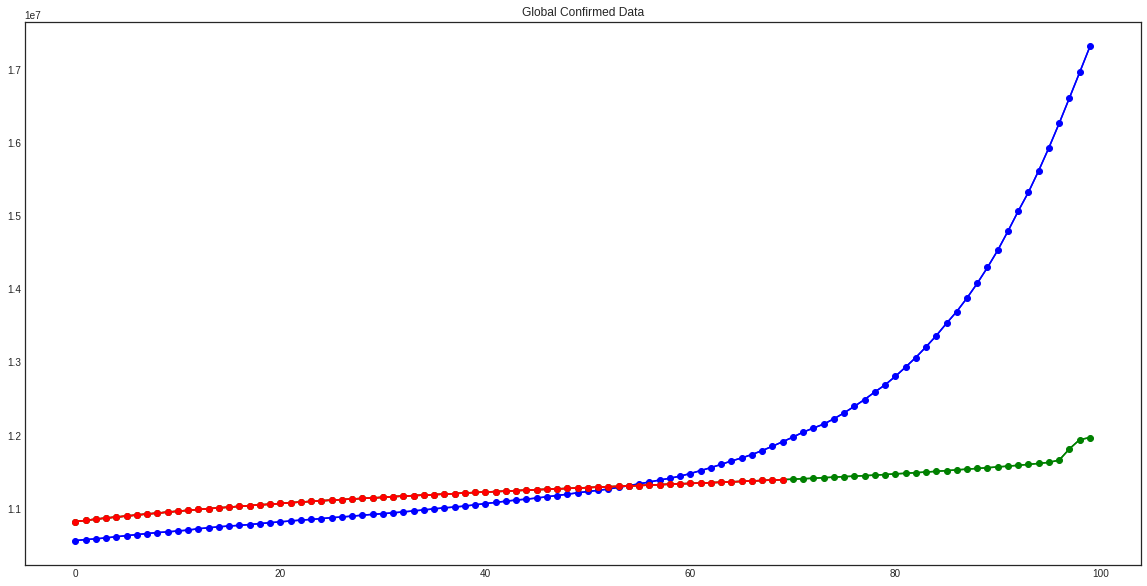

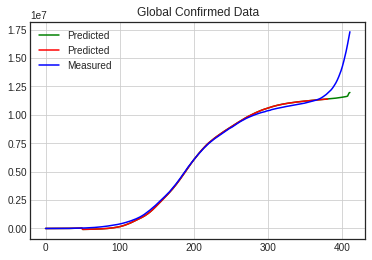

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  3.11s | mse loss 0.31516 | rmsle loss 0.22072 
-----------------------------------------------------------------------------------------
| epoch  61 |     1/    6 batches | lr 0.000219 | 48.98 ms | loss 0.00190 | ppl     1.00
| epoch  61 |     2/    6 batches | lr 0.000219 | 24.44 ms | loss 0.00199 | ppl     1.00
| epoch  61 |     3/    6 batches | lr 0.000219 | 24.35 ms | loss 0.00301 | ppl     1.00
| epoch  61 |     4/    6 batches | lr 0.000219 | 24.23 ms | loss 0.00087 | ppl     1.00
| epoch  61 |     5/    6 batches | lr 0.000219 | 24.33 ms | loss 0.00106 | ppl     1.00
| epoch  61 |     6/    6 batches | lr 0.000219 | 25.58 ms | loss 0.00393 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  62 |     1/    6 batches | lr 0.000208 | 54.48 ms | loss 0.00237 | ppl     1.00
| epoch  62 |     2/    6 batches | lr 0.000208 | 29.98 ms | loss 0.00112 | ppl     1.00
| epoch  62 |     3/    6 batches | lr 0.000208 | 26.24 ms | loss 0.00266 | ppl     1.00
| epoch  62 |     4/    6 batches | lr 0.000208 | 25.36 ms | loss 0.00101 | ppl     1.00
| epoch  62 |     5/    6 batches | lr 0.000208 | 39.55 ms | loss 0.00074 | ppl     1.00
| epoch  62 |     6/    6 batches | lr 0.000208 | 28.55 ms | loss 0.00342 | ppl     1.00
| epoch  63 |     1/    6 batches | lr 0.000197 | 52.58 ms | loss 0.00248 | ppl     1.00
| epoch  63 |     2/    6 batches | lr 0.000197 | 24.72 ms | loss 0.00202 | ppl     1.00
| epoch  63 |     3/    6 batches | lr 0.000197 | 39.10 ms | loss 0.00239 | ppl     1.00
| epoch  63 |     4/    6 batches | lr 0.000197 | 25.34 ms | loss 0.00105 | ppl     1.00
| epoch  63 |     5/    6 batches | lr 0.000197 | 24.06 ms | loss 0.00070 | ppl     1.00
| epoch  63 |     6/ 

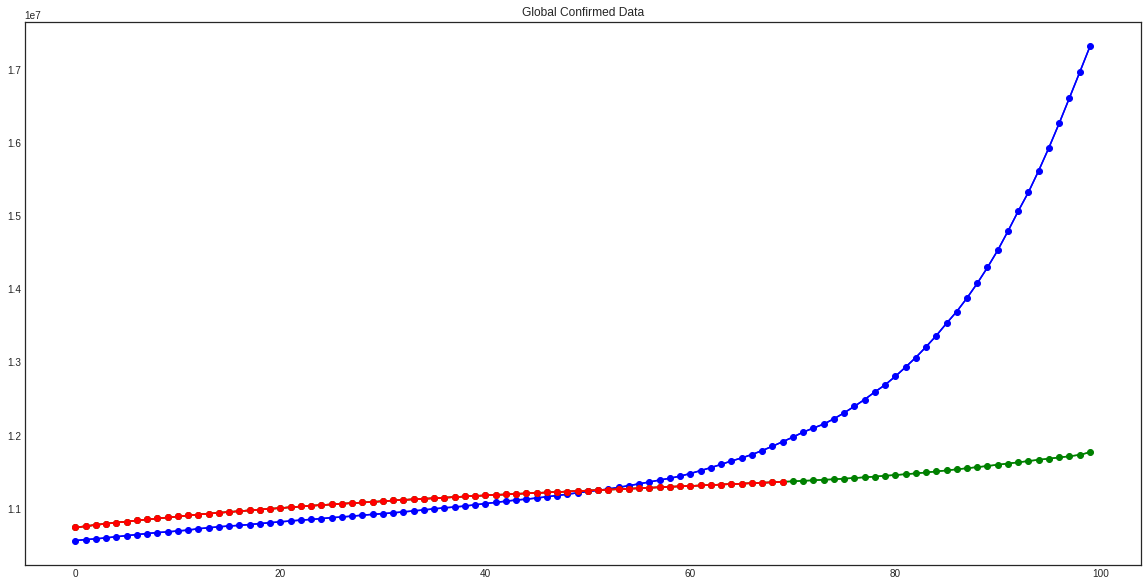

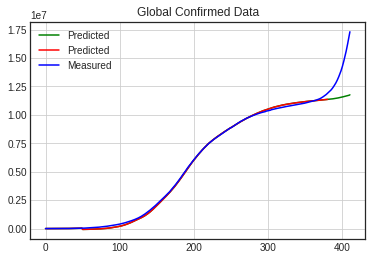

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  2.86s | mse loss 0.31982 | rmsle loss 0.22243 
-----------------------------------------------------------------------------------------
| epoch  71 |     1/    6 batches | lr 0.000131 | 52.79 ms | loss 0.00208 | ppl     1.00
| epoch  71 |     2/    6 batches | lr 0.000131 | 24.66 ms | loss 0.00095 | ppl     1.00
| epoch  71 |     3/    6 batches | lr 0.000131 | 38.65 ms | loss 0.00301 | ppl     1.00
| epoch  71 |     4/    6 batches | lr 0.000131 | 32.23 ms | loss 0.00113 | ppl     1.00
| epoch  71 |     5/    6 batches | lr 0.000131 | 33.13 ms | loss 0.00062 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  71 |     6/    6 batches | lr 0.000131 | 23.89 ms | loss 0.00292 | ppl     1.00
| epoch  72 |     1/    6 batches | lr 0.000124 | 52.76 ms | loss 0.00222 | ppl     1.00
| epoch  72 |     2/    6 batches | lr 0.000124 | 24.41 ms | loss 0.00173 | ppl     1.00
| epoch  72 |     3/    6 batches | lr 0.000124 | 24.61 ms | loss 0.00244 | ppl     1.00
| epoch  72 |     4/    6 batches | lr 0.000124 | 25.55 ms | loss 0.00114 | ppl     1.00
| epoch  72 |     5/    6 batches | lr 0.000124 | 24.99 ms | loss 0.00091 | ppl     1.00
| epoch  72 |     6/    6 batches | lr 0.000124 | 23.45 ms | loss 0.00343 | ppl     1.00
| epoch  73 |     1/    6 batches | lr 0.000118 | 49.53 ms | loss 0.00209 | ppl     1.00
| epoch  73 |     2/    6 batches | lr 0.000118 | 24.41 ms | loss 0.00114 | ppl     1.00
| epoch  73 |     3/    6 batches | lr 0.000118 | 24.29 ms | loss 0.00288 | ppl     1.00
| epoch  73 |     4/    6 batches | lr 0.000118 | 24.46 ms | loss 0.00094 | ppl     1.00
| epoch  73 |     5/ 

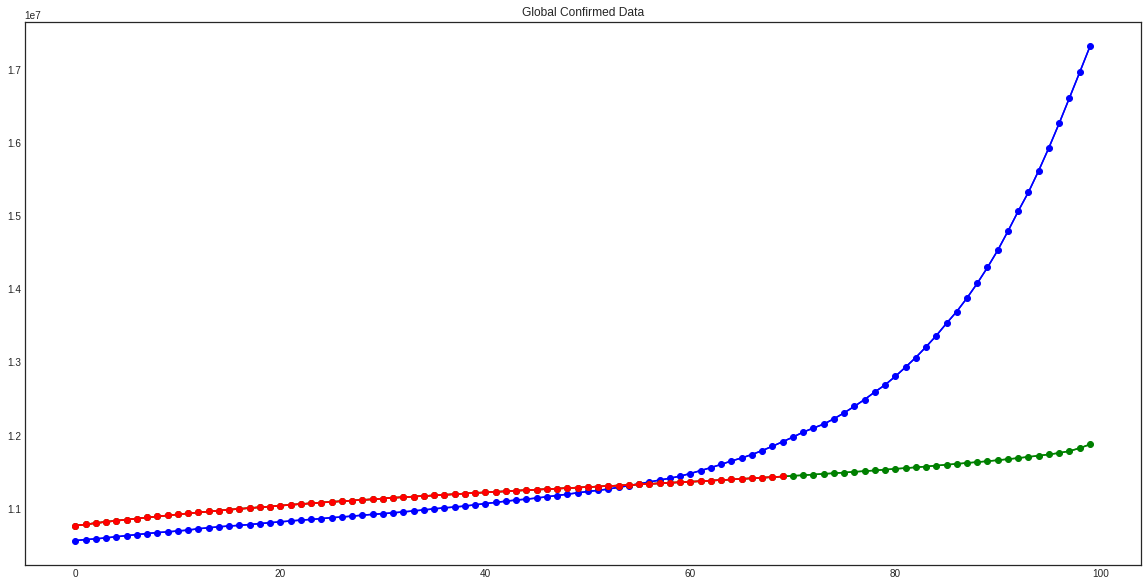

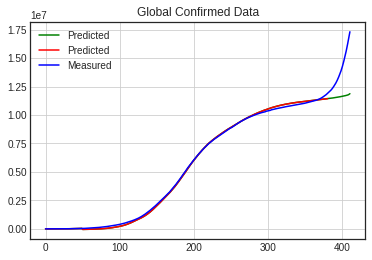

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  2.82s | mse loss 0.30566 | rmsle loss 0.21642 
-----------------------------------------------------------------------------------------
| epoch  81 |     1/    6 batches | lr 0.000078 | 84.72 ms | loss 0.00231 | ppl     1.00
| epoch  81 |     2/    6 batches | lr 0.000078 | 29.28 ms | loss 0.00104 | ppl     1.00
| epoch  81 |     3/    6 batches | lr 0.000078 | 24.30 ms | loss 0.00233 | ppl     1.00
| epoch  81 |     4/    6 batches | lr 0.000078 | 23.79 ms | loss 0.00111 | ppl     1.00
| epoch  81 |     5/    6 batches | lr 0.000078 | 24.20 ms | loss 0.00090 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  81 |     6/    6 batches | lr 0.000078 | 23.06 ms | loss 0.00312 | ppl     1.00
| epoch  82 |     1/    6 batches | lr 0.000075 | 48.28 ms | loss 0.00221 | ppl     1.00
| epoch  82 |     2/    6 batches | lr 0.000075 | 23.94 ms | loss 0.00126 | ppl     1.00
| epoch  82 |     3/    6 batches | lr 0.000075 | 26.97 ms | loss 0.00211 | ppl     1.00
| epoch  82 |     4/    6 batches | lr 0.000075 | 24.11 ms | loss 0.00069 | ppl     1.00
| epoch  82 |     5/    6 batches | lr 0.000075 | 23.96 ms | loss 0.00108 | ppl     1.00
| epoch  82 |     6/    6 batches | lr 0.000075 | 22.70 ms | loss 0.00346 | ppl     1.00
| epoch  83 |     1/    6 batches | lr 0.000071 | 48.40 ms | loss 0.00243 | ppl     1.00
| epoch  83 |     2/    6 batches | lr 0.000071 | 24.22 ms | loss 0.00125 | ppl     1.00
| epoch  83 |     3/    6 batches | lr 0.000071 | 24.33 ms | loss 0.00183 | ppl     1.00
| epoch  83 |     4/    6 batches | lr 0.000071 | 24.40 ms | loss 0.00099 | ppl     1.00
| epoch  83 |     5/ 

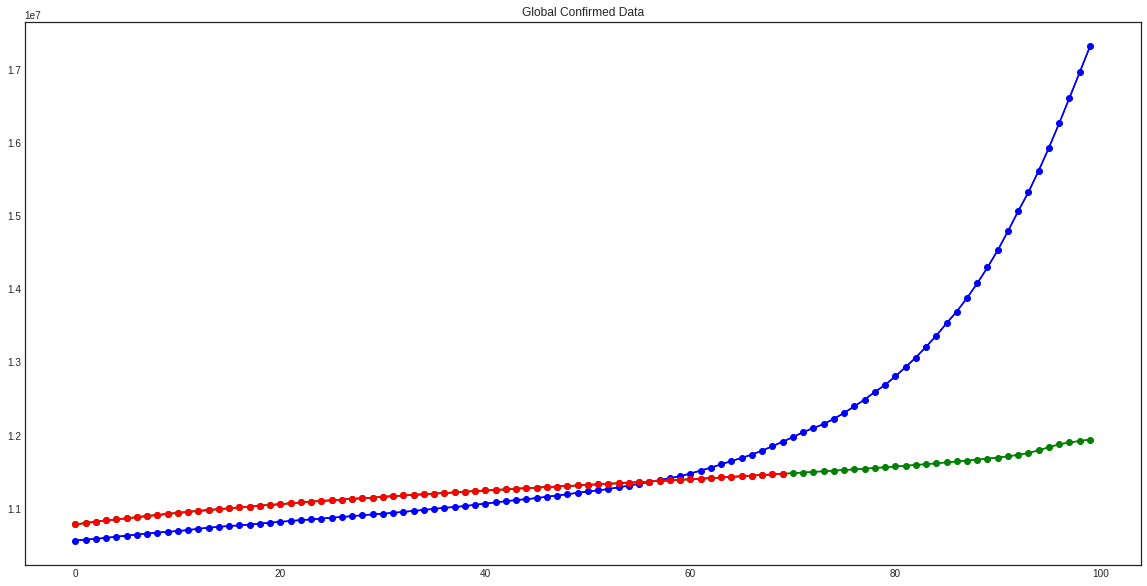

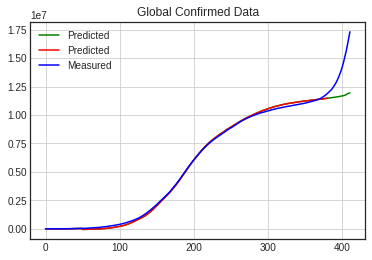

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  2.83s | mse loss 0.29428 | rmsle loss 0.21167 
-----------------------------------------------------------------------------------------
| epoch  91 |     1/    6 batches | lr 0.000047 | 48.43 ms | loss 0.00208 | ppl     1.00
| epoch  91 |     2/    6 batches | lr 0.000047 | 24.09 ms | loss 0.00139 | ppl     1.00
| epoch  91 |     3/    6 batches | lr 0.000047 | 24.03 ms | loss 0.00241 | ppl     1.00
| epoch  91 |     4/    6 batches | lr 0.000047 | 24.28 ms | loss 0.00067 | ppl     1.00
| epoch  91 |     5/    6 batches | lr 0.000047 | 24.14 ms | loss 0.00070 | ppl     1.00
| epoch  91 |     6/    6 batches | lr 0.000047 | 22.67 ms | loss 0.00309 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  92 |     1/    6 batches | lr 0.000045 | 50.69 ms | loss 0.00187 | ppl     1.00
| epoch  92 |     2/    6 batches | lr 0.000045 | 24.30 ms | loss 0.00095 | ppl     1.00
| epoch  92 |     3/    6 batches | lr 0.000045 | 25.03 ms | loss 0.00240 | ppl     1.00
| epoch  92 |     4/    6 batches | lr 0.000045 | 24.13 ms | loss 0.00155 | ppl     1.00
| epoch  92 |     5/    6 batches | lr 0.000045 | 29.29 ms | loss 0.00099 | ppl     1.00
| epoch  92 |     6/    6 batches | lr 0.000045 | 22.66 ms | loss 0.00332 | ppl     1.00
| epoch  93 |     1/    6 batches | lr 0.000042 | 48.42 ms | loss 0.00250 | ppl     1.00
| epoch  93 |     2/    6 batches | lr 0.000042 | 34.15 ms | loss 0.00115 | ppl     1.00
| epoch  93 |     3/    6 batches | lr 0.000042 | 24.07 ms | loss 0.00239 | ppl     1.00
| epoch  93 |     4/    6 batches | lr 0.000042 | 27.91 ms | loss 0.00103 | ppl     1.00
| epoch  93 |     5/    6 batches | lr 0.000042 | 24.20 ms | loss 0.00084 | ppl     1.00
| epoch  93 |     6/ 

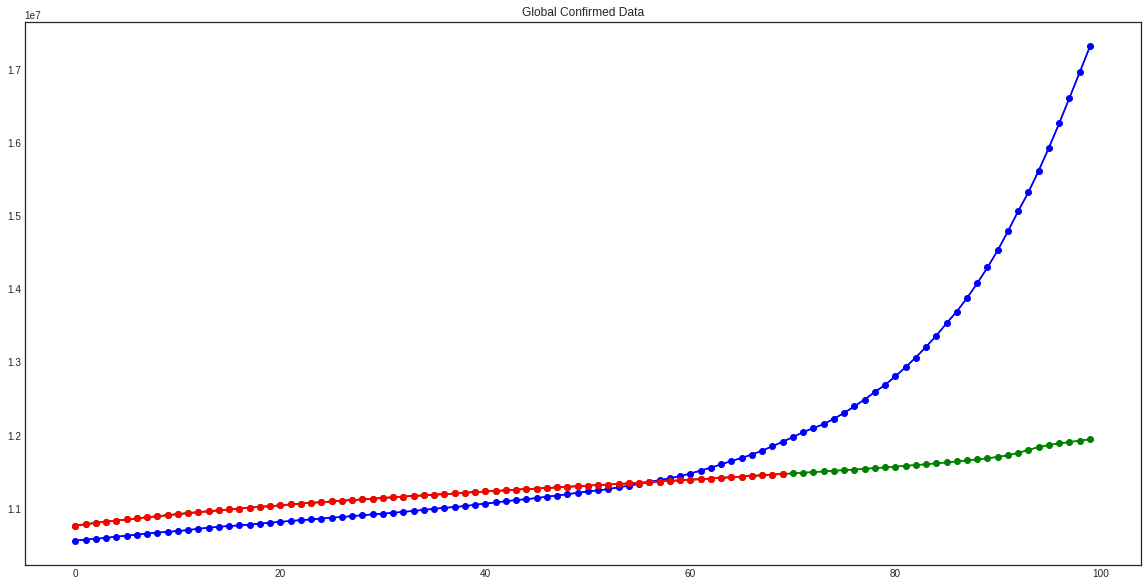

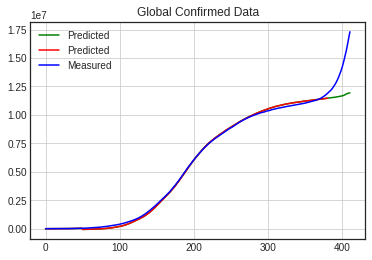

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  2.82s | mse loss 0.29227 | rmsle loss 0.21084 
-----------------------------------------------------------------------------------------
| epoch 101 |     1/    6 batches | lr 0.000028 | 53.68 ms | loss 0.00195 | ppl     1.00
| epoch 101 |     2/    6 batches | lr 0.000028 | 24.24 ms | loss 0.00119 | ppl     1.00
| epoch 101 |     3/    6 batches | lr 0.000028 | 23.94 ms | loss 0.00208 | ppl     1.00
| epoch 101 |     4/    6 batches | lr 0.000028 | 24.01 ms | loss 0.00103 | ppl     1.00
| epoch 101 |     5/    6 batches | lr 0.000028 | 24.06 ms | loss 0.00097 | ppl     1.00
| epoch 101 |     6/    6 batches | lr 0.000028 | 22.58 ms | loss 0.00339 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 102 |     1/    6 batches | lr 0.000027 | 48.43 ms | loss 0.00201 | ppl     1.00
| epoch 102 |     2/    6 batches | lr 0.000027 | 24.31 ms | loss 0.00121 | ppl     1.00
| epoch 102 |     3/    6 batches | lr 0.000027 | 25.03 ms | loss 0.00239 | ppl     1.00
| epoch 102 |     4/    6 batches | lr 0.000027 | 23.73 ms | loss 0.00073 | ppl     1.00
| epoch 102 |     5/    6 batches | lr 0.000027 | 24.24 ms | loss 0.00079 | ppl     1.00
| epoch 102 |     6/    6 batches | lr 0.000027 | 22.69 ms | loss 0.00284 | ppl     1.00
| epoch 103 |     1/    6 batches | lr 0.000025 | 50.38 ms | loss 0.00240 | ppl     1.00
| epoch 103 |     2/    6 batches | lr 0.000025 | 24.03 ms | loss 0.00128 | ppl     1.00
| epoch 103 |     3/    6 batches | lr 0.000025 | 24.48 ms | loss 0.00241 | ppl     1.00
| epoch 103 |     4/    6 batches | lr 0.000025 | 23.97 ms | loss 0.00107 | ppl     1.00
| epoch 103 |     5/    6 batches | lr 0.000025 | 38.27 ms | loss 0.00082 | ppl     1.00
| epoch 103 |     6/ 

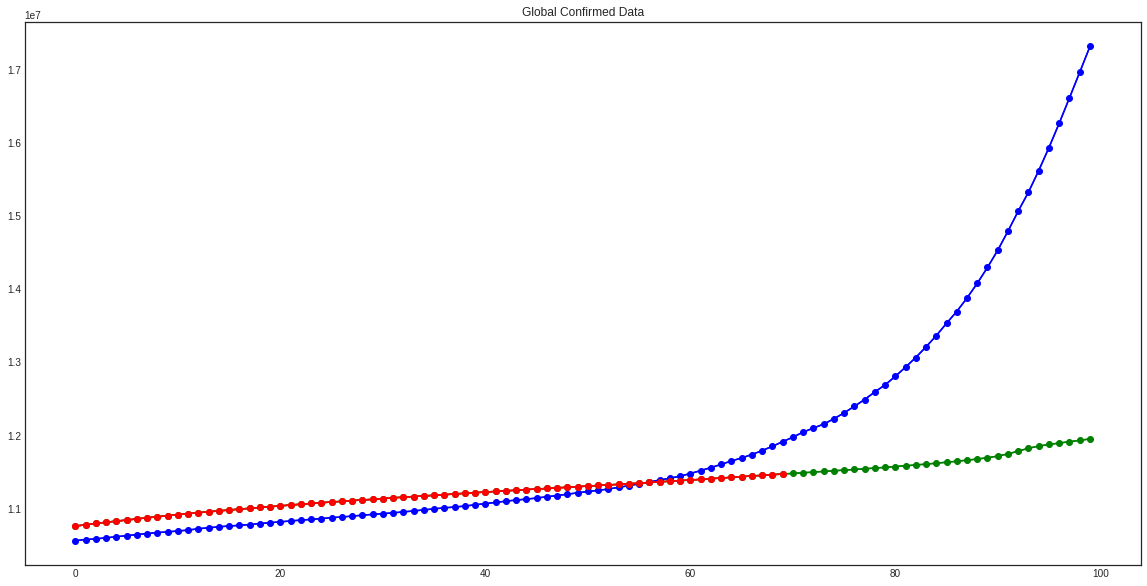

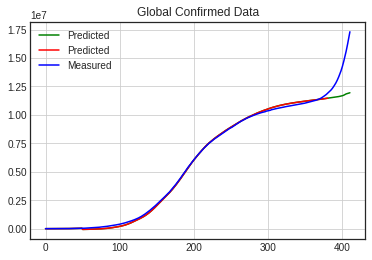

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  2.80s | mse loss 0.29096 | rmsle loss 0.21028 
-----------------------------------------------------------------------------------------
| epoch 111 |     1/    6 batches | lr 0.000017 | 57.70 ms | loss 0.00208 | ppl     1.00
| epoch 111 |     2/    6 batches | lr 0.000017 | 24.26 ms | loss 0.00116 | ppl     1.00
| epoch 111 |     3/    6 batches | lr 0.000017 | 23.97 ms | loss 0.00201 | ppl     1.00
| epoch 111 |     4/    6 batches | lr 0.000017 | 23.83 ms | loss 0.00083 | ppl     1.00
| epoch 111 |     5/    6 batches | lr 0.000017 | 24.27 ms | loss 0.00094 | ppl     1.00
| epoch 111 |     6/    6 batches | lr 0.000017 | 22.51 ms | loss 0.00270 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 112 |     1/    6 batches | lr 0.000016 | 49.11 ms | loss 0.00191 | ppl     1.00
| epoch 112 |     2/    6 batches | lr 0.000016 | 25.20 ms | loss 0.00112 | ppl     1.00
| epoch 112 |     3/    6 batches | lr 0.000016 | 27.16 ms | loss 0.00198 | ppl     1.00
| epoch 112 |     4/    6 batches | lr 0.000016 | 24.67 ms | loss 0.00068 | ppl     1.00
| epoch 112 |     5/    6 batches | lr 0.000016 | 23.98 ms | loss 0.00076 | ppl     1.00
| epoch 112 |     6/    6 batches | lr 0.000016 | 32.99 ms | loss 0.00199 | ppl     1.00
| epoch 113 |     1/    6 batches | lr 0.000015 | 48.55 ms | loss 0.00202 | ppl     1.00
| epoch 113 |     2/    6 batches | lr 0.000015 | 27.89 ms | loss 0.00114 | ppl     1.00
| epoch 113 |     3/    6 batches | lr 0.000015 | 25.81 ms | loss 0.00183 | ppl     1.00
| epoch 113 |     4/    6 batches | lr 0.000015 | 27.84 ms | loss 0.00119 | ppl     1.00
| epoch 113 |     5/    6 batches | lr 0.000015 | 23.18 ms | loss 0.00101 | ppl     1.00
| epoch 113 |     6/ 

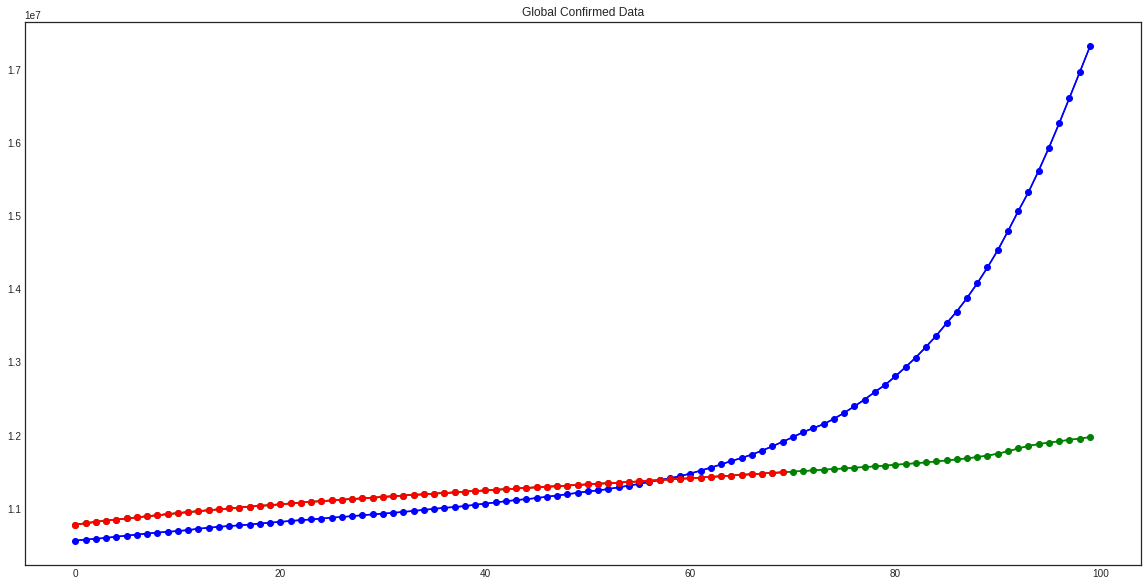

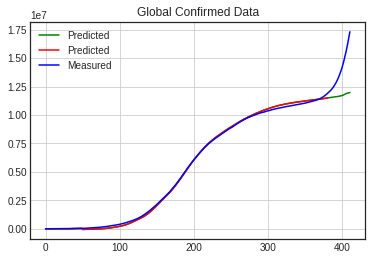

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  2.85s | mse loss 0.28599 | rmsle loss 0.20811 
-----------------------------------------------------------------------------------------
| epoch 121 |     1/    6 batches | lr 0.000010 | 54.01 ms | loss 0.00220 | ppl     1.00
| epoch 121 |     2/    6 batches | lr 0.000010 | 24.24 ms | loss 0.00154 | ppl     1.00
| epoch 121 |     3/    6 batches | lr 0.000010 | 24.14 ms | loss 0.00256 | ppl     1.00
| epoch 121 |     4/    6 batches | lr 0.000010 | 24.25 ms | loss 0.00091 | ppl     1.00
| epoch 121 |     5/    6 batches | lr 0.000010 | 29.44 ms | loss 0.00073 | ppl     1.00
| epoch 121 |     6/    6 batches | lr 0.000010 | 22.57 ms | loss 0.00210 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 122 |     1/    6 batches | lr 0.000010 | 49.77 ms | loss 0.00241 | ppl     1.00
| epoch 122 |     2/    6 batches | lr 0.000010 | 36.33 ms | loss 0.00117 | ppl     1.00
| epoch 122 |     3/    6 batches | lr 0.000010 | 26.82 ms | loss 0.00217 | ppl     1.00
| epoch 122 |     4/    6 batches | lr 0.000010 | 26.00 ms | loss 0.00126 | ppl     1.00
| epoch 122 |     5/    6 batches | lr 0.000010 | 23.68 ms | loss 0.00081 | ppl     1.00
| epoch 122 |     6/    6 batches | lr 0.000010 | 22.72 ms | loss 0.00280 | ppl     1.00
| epoch 123 |     1/    6 batches | lr 0.000009 | 52.64 ms | loss 0.00234 | ppl     1.00
| epoch 123 |     2/    6 batches | lr 0.000009 | 24.22 ms | loss 0.00142 | ppl     1.00
| epoch 123 |     3/    6 batches | lr 0.000009 | 24.19 ms | loss 0.00205 | ppl     1.00
| epoch 123 |     4/    6 batches | lr 0.000009 | 24.42 ms | loss 0.00099 | ppl     1.00
| epoch 123 |     5/    6 batches | lr 0.000009 | 24.18 ms | loss 0.00073 | ppl     1.00
| epoch 123 |     6/ 

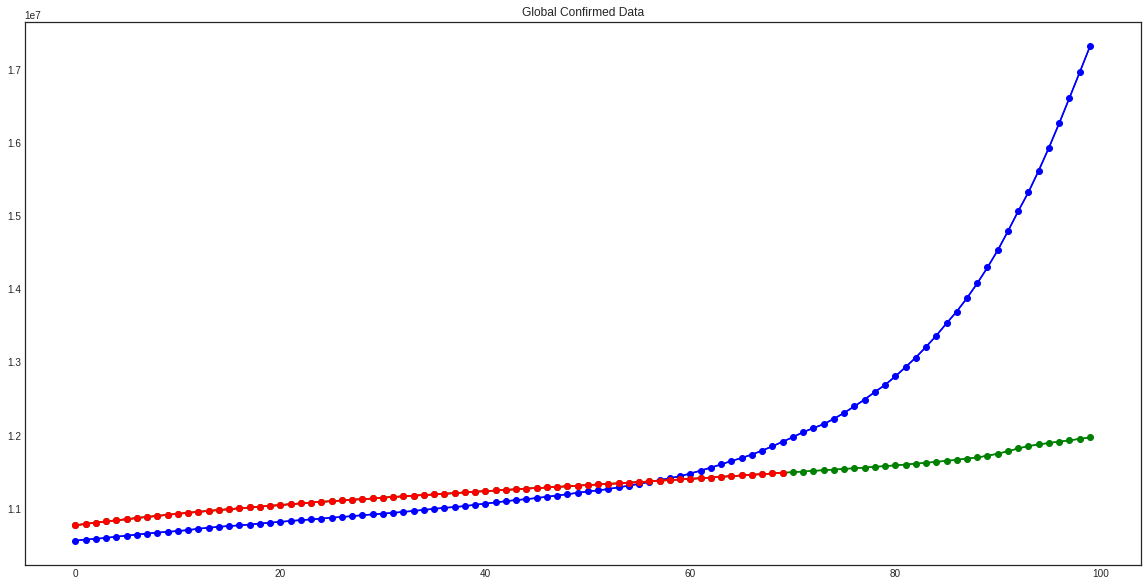

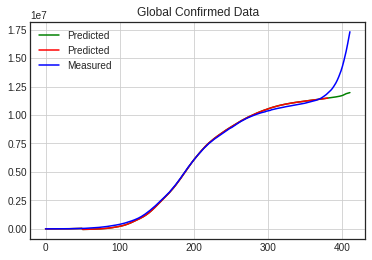

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  2.86s | mse loss 0.28684 | rmsle loss 0.20849 
-----------------------------------------------------------------------------------------
| epoch 131 |     1/    6 batches | lr 0.000006 | 63.86 ms | loss 0.00203 | ppl     1.00
| epoch 131 |     2/    6 batches | lr 0.000006 | 25.38 ms | loss 0.00129 | ppl     1.00
| epoch 131 |     3/    6 batches | lr 0.000006 | 28.46 ms | loss 0.00225 | ppl     1.00
| epoch 131 |     4/    6 batches | lr 0.000006 | 26.15 ms | loss 0.00114 | ppl     1.00
| epoch 131 |     5/    6 batches | lr 0.000006 | 23.98 ms | loss 0.00060 | ppl     1.00
| epoch 131 |     6/    6 batches | lr 0.000006 | 22.56 ms | loss 0.00244 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 132 |     1/    6 batches | lr 0.000006 | 49.32 ms | loss 0.00228 | ppl     1.00
| epoch 132 |     2/    6 batches | lr 0.000006 | 24.99 ms | loss 0.00129 | ppl     1.00
| epoch 132 |     3/    6 batches | lr 0.000006 | 24.18 ms | loss 0.00271 | ppl     1.00
| epoch 132 |     4/    6 batches | lr 0.000006 | 24.29 ms | loss 0.00097 | ppl     1.00
| epoch 132 |     5/    6 batches | lr 0.000006 | 24.24 ms | loss 0.00079 | ppl     1.00
| epoch 132 |     6/    6 batches | lr 0.000006 | 26.45 ms | loss 0.00208 | ppl     1.00
| epoch 133 |     1/    6 batches | lr 0.000005 | 48.53 ms | loss 0.00210 | ppl     1.00
| epoch 133 |     2/    6 batches | lr 0.000005 | 24.15 ms | loss 0.00175 | ppl     1.00
| epoch 133 |     3/    6 batches | lr 0.000005 | 24.41 ms | loss 0.00213 | ppl     1.00
| epoch 133 |     4/    6 batches | lr 0.000005 | 24.08 ms | loss 0.00117 | ppl     1.00
| epoch 133 |     5/    6 batches | lr 0.000005 | 24.15 ms | loss 0.00079 | ppl     1.00
| epoch 133 |     6/ 

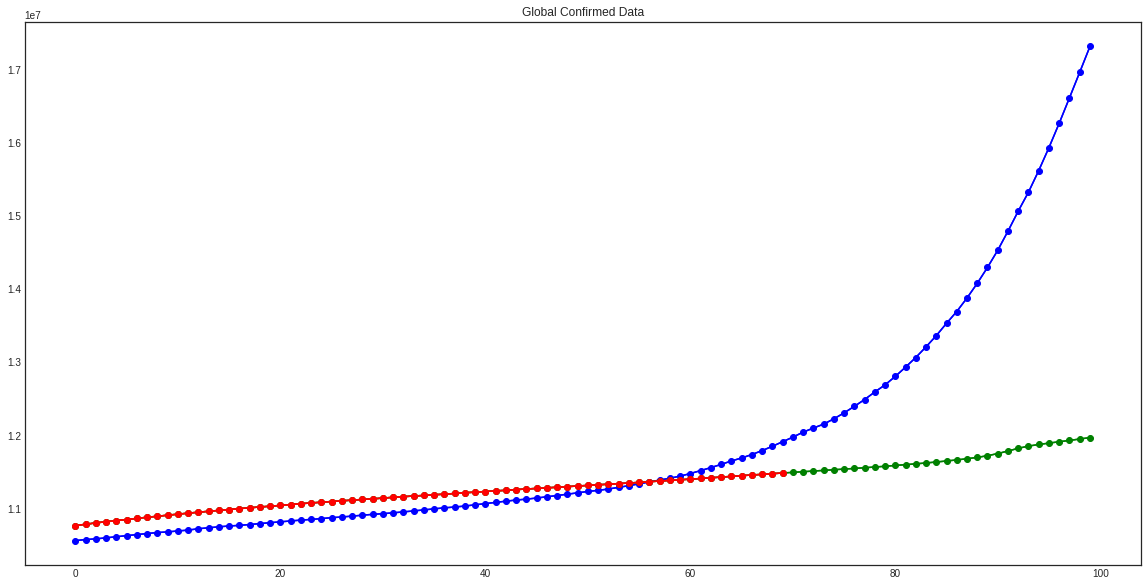

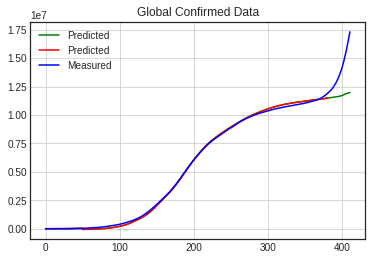

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  2.84s | mse loss 0.28703 | rmsle loss 0.20857 
-----------------------------------------------------------------------------------------
| epoch 141 |     1/    6 batches | lr 0.000004 | 48.62 ms | loss 0.00202 | ppl     1.00
| epoch 141 |     2/    6 batches | lr 0.000004 | 24.32 ms | loss 0.00102 | ppl     1.00
| epoch 141 |     3/    6 batches | lr 0.000004 | 24.04 ms | loss 0.00217 | ppl     1.00
| epoch 141 |     4/    6 batches | lr 0.000004 | 23.99 ms | loss 0.00095 | ppl     1.00
| epoch 141 |     5/    6 batches | lr 0.000004 | 24.13 ms | loss 0.00073 | ppl     1.00
| epoch 141 |     6/    6 batches | lr 0.000004 | 26.55 ms | loss 0.00259 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 142 |     1/    6 batches | lr 0.000003 | 48.95 ms | loss 0.00192 | ppl     1.00
| epoch 142 |     2/    6 batches | lr 0.000003 | 24.51 ms | loss 0.00113 | ppl     1.00
| epoch 142 |     3/    6 batches | lr 0.000003 | 37.97 ms | loss 0.00200 | ppl     1.00
| epoch 142 |     4/    6 batches | lr 0.000003 | 25.55 ms | loss 0.00083 | ppl     1.00
| epoch 142 |     5/    6 batches | lr 0.000003 | 28.51 ms | loss 0.00072 | ppl     1.00
| epoch 142 |     6/    6 batches | lr 0.000003 | 22.90 ms | loss 0.00249 | ppl     1.00
| epoch 143 |     1/    6 batches | lr 0.000003 | 63.08 ms | loss 0.00227 | ppl     1.00
| epoch 143 |     2/    6 batches | lr 0.000003 | 24.18 ms | loss 0.00109 | ppl     1.00
| epoch 143 |     3/    6 batches | lr 0.000003 | 24.20 ms | loss 0.00166 | ppl     1.00
| epoch 143 |     4/    6 batches | lr 0.000003 | 23.88 ms | loss 0.00074 | ppl     1.00
| epoch 143 |     5/    6 batches | lr 0.000003 | 26.21 ms | loss 0.00076 | ppl     1.00
| epoch 143 |     6/ 

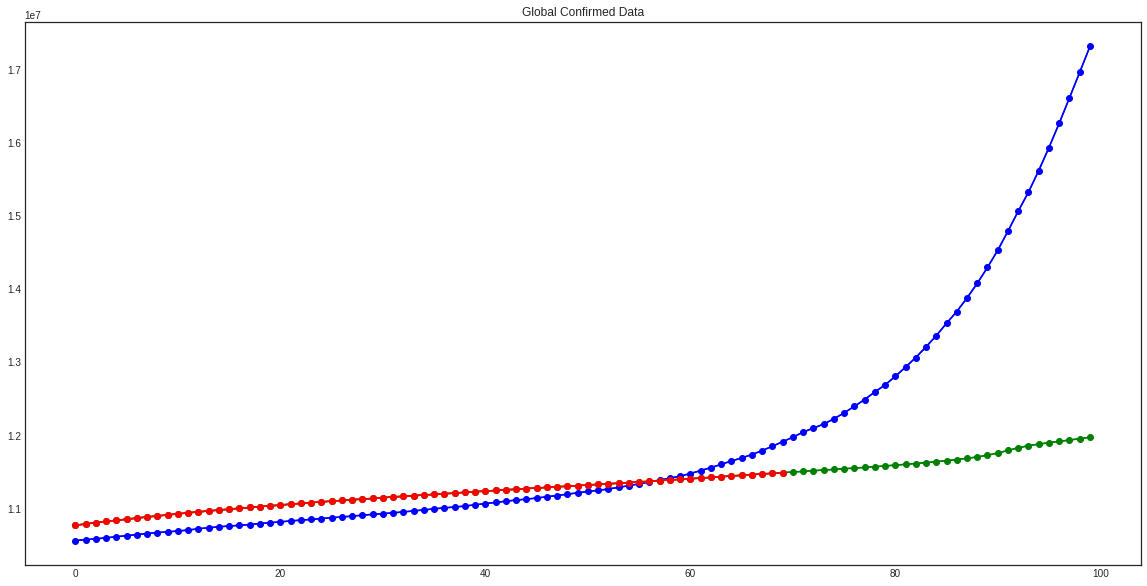

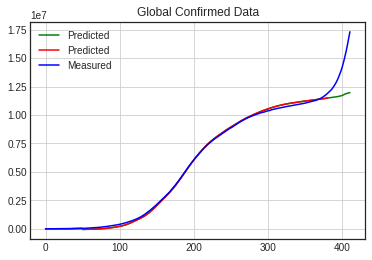

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  2.90s | mse loss 0.28603 | rmsle loss 0.20814 
-----------------------------------------------------------------------------------------
| epoch 151 |     1/    6 batches | lr 0.000002 | 49.19 ms | loss 0.00215 | ppl     1.00
| epoch 151 |     2/    6 batches | lr 0.000002 | 23.90 ms | loss 0.00101 | ppl     1.00
| epoch 151 |     3/    6 batches | lr 0.000002 | 24.89 ms | loss 0.00208 | ppl     1.00
| epoch 151 |     4/    6 batches | lr 0.000002 | 24.01 ms | loss 0.00111 | ppl     1.00
| epoch 151 |     5/    6 batches | lr 0.000002 | 24.18 ms | loss 0.00085 | ppl     1.00
| epoch 151 |     6/    6 batches | lr 0.000002 | 22.72 ms | loss 0.00236 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 152 |     1/    6 batches | lr 0.000002 | 48.41 ms | loss 0.00170 | ppl     1.00
| epoch 152 |     2/    6 batches | lr 0.000002 | 24.23 ms | loss 0.00119 | ppl     1.00
| epoch 152 |     3/    6 batches | lr 0.000002 | 24.26 ms | loss 0.00207 | ppl     1.00
| epoch 152 |     4/    6 batches | lr 0.000002 | 24.30 ms | loss 0.00094 | ppl     1.00
| epoch 152 |     5/    6 batches | lr 0.000002 | 23.82 ms | loss 0.00077 | ppl     1.00
| epoch 152 |     6/    6 batches | lr 0.000002 | 22.79 ms | loss 0.00218 | ppl     1.00
| epoch 153 |     1/    6 batches | lr 0.000002 | 51.60 ms | loss 0.00207 | ppl     1.00
| epoch 153 |     2/    6 batches | lr 0.000002 | 25.42 ms | loss 0.00121 | ppl     1.00
| epoch 153 |     3/    6 batches | lr 0.000002 | 24.15 ms | loss 0.00195 | ppl     1.00
| epoch 153 |     4/    6 batches | lr 0.000002 | 24.37 ms | loss 0.00070 | ppl     1.00
| epoch 153 |     5/    6 batches | lr 0.000002 | 44.79 ms | loss 0.00073 | ppl     1.00
| epoch 153 |     6/ 

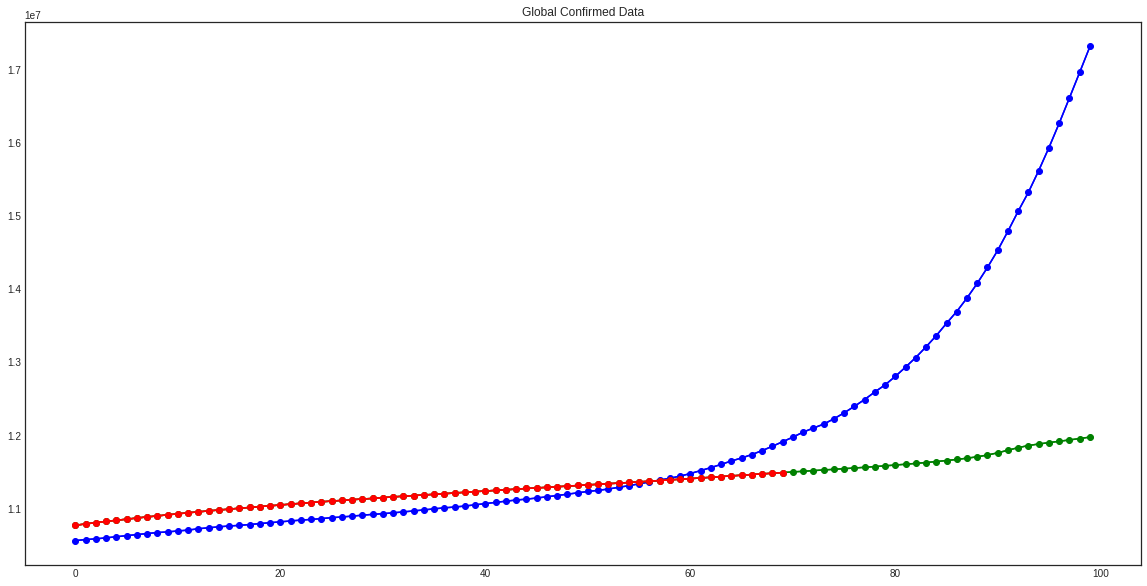

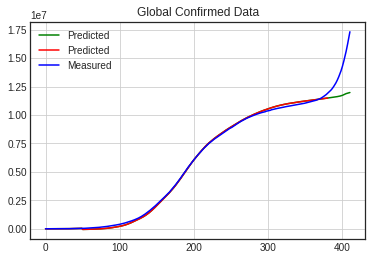

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  2.90s | mse loss 0.28571 | rmsle loss 0.20800 
-----------------------------------------------------------------------------------------
| epoch 161 |     1/    6 batches | lr 0.000001 | 53.10 ms | loss 0.00171 | ppl     1.00
| epoch 161 |     2/    6 batches | lr 0.000001 | 24.22 ms | loss 0.00123 | ppl     1.00
| epoch 161 |     3/    6 batches | lr 0.000001 | 24.28 ms | loss 0.00217 | ppl     1.00
| epoch 161 |     4/    6 batches | lr 0.000001 | 24.17 ms | loss 0.00087 | ppl     1.00
| epoch 161 |     5/    6 batches | lr 0.000001 | 24.12 ms | loss 0.00078 | ppl     1.00
| epoch 161 |     6/    6 batches | lr 0.000001 | 22.49 ms | loss 0.00276 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 162 |     1/    6 batches | lr 0.000001 | 48.15 ms | loss 0.00204 | ppl     1.00
| epoch 162 |     2/    6 batches | lr 0.000001 | 24.36 ms | loss 0.00125 | ppl     1.00
| epoch 162 |     3/    6 batches | lr 0.000001 | 24.76 ms | loss 0.00182 | ppl     1.00
| epoch 162 |     4/    6 batches | lr 0.000001 | 23.95 ms | loss 0.00076 | ppl     1.00
| epoch 162 |     5/    6 batches | lr 0.000001 | 24.34 ms | loss 0.00078 | ppl     1.00
| epoch 162 |     6/    6 batches | lr 0.000001 | 24.97 ms | loss 0.00232 | ppl     1.00
| epoch 163 |     1/    6 batches | lr 0.000001 | 54.56 ms | loss 0.00218 | ppl     1.00
| epoch 163 |     2/    6 batches | lr 0.000001 | 27.93 ms | loss 0.00132 | ppl     1.00
| epoch 163 |     3/    6 batches | lr 0.000001 | 23.77 ms | loss 0.00185 | ppl     1.00
| epoch 163 |     4/    6 batches | lr 0.000001 | 26.10 ms | loss 0.00085 | ppl     1.00
| epoch 163 |     5/    6 batches | lr 0.000001 | 24.22 ms | loss 0.00054 | ppl     1.00
| epoch 163 |     6/ 

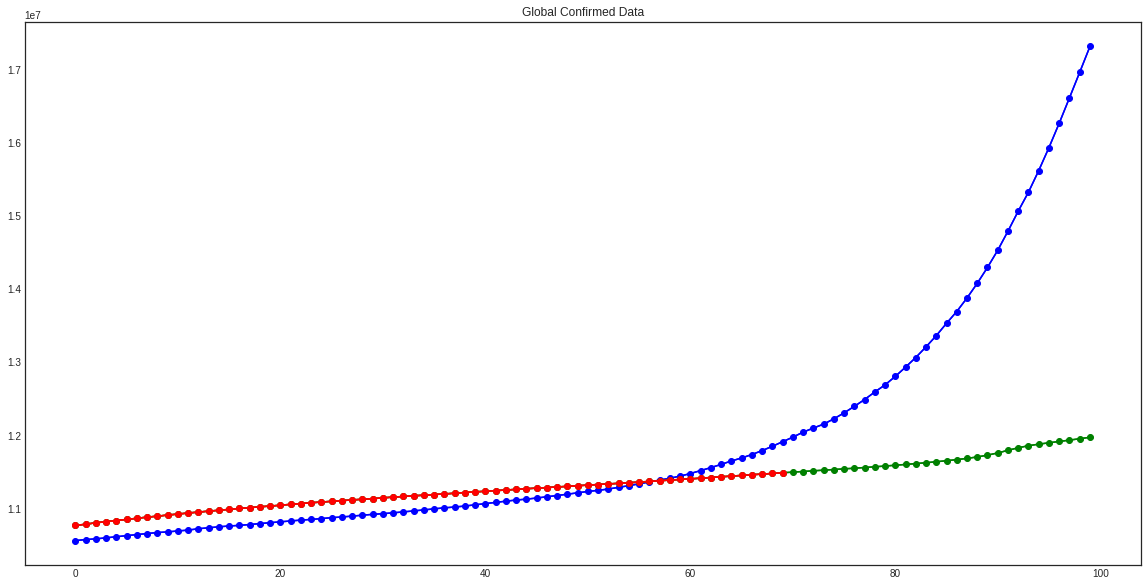

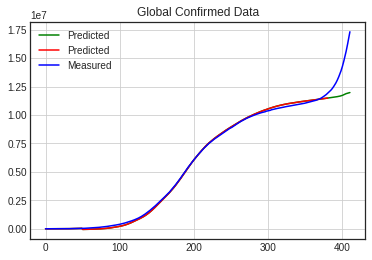

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  2.85s | mse loss 0.28615 | rmsle loss 0.20819 
-----------------------------------------------------------------------------------------
| epoch 171 |     1/    6 batches | lr 0.000001 | 51.21 ms | loss 0.00207 | ppl     1.00
| epoch 171 |     2/    6 batches | lr 0.000001 | 24.78 ms | loss 0.00130 | ppl     1.00
| epoch 171 |     3/    6 batches | lr 0.000001 | 46.02 ms | loss 0.00237 | ppl     1.00
| epoch 171 |     4/    6 batches | lr 0.000001 | 31.08 ms | loss 0.00124 | ppl     1.00
| epoch 171 |     5/    6 batches | lr 0.000001 | 24.03 ms | loss 0.00081 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 171 |     6/    6 batches | lr 0.000001 | 25.46 ms | loss 0.00309 | ppl     1.00
| epoch 172 |     1/    6 batches | lr 0.000001 | 53.56 ms | loss 0.00202 | ppl     1.00
| epoch 172 |     2/    6 batches | lr 0.000001 | 27.74 ms | loss 0.00119 | ppl     1.00
| epoch 172 |     3/    6 batches | lr 0.000001 | 25.47 ms | loss 0.00308 | ppl     1.00
| epoch 172 |     4/    6 batches | lr 0.000001 | 24.65 ms | loss 0.00082 | ppl     1.00
| epoch 172 |     5/    6 batches | lr 0.000001 | 24.16 ms | loss 0.00105 | ppl     1.00
| epoch 172 |     6/    6 batches | lr 0.000001 | 22.67 ms | loss 0.00229 | ppl     1.00
| epoch 173 |     1/    6 batches | lr 0.000001 | 49.16 ms | loss 0.00223 | ppl     1.00
| epoch 173 |     2/    6 batches | lr 0.000001 | 24.17 ms | loss 0.00117 | ppl     1.00
| epoch 173 |     3/    6 batches | lr 0.000001 | 25.31 ms | loss 0.00172 | ppl     1.00
| epoch 173 |     4/    6 batches | lr 0.000001 | 24.35 ms | loss 0.00075 | ppl     1.00
| epoch 173 |     5/ 

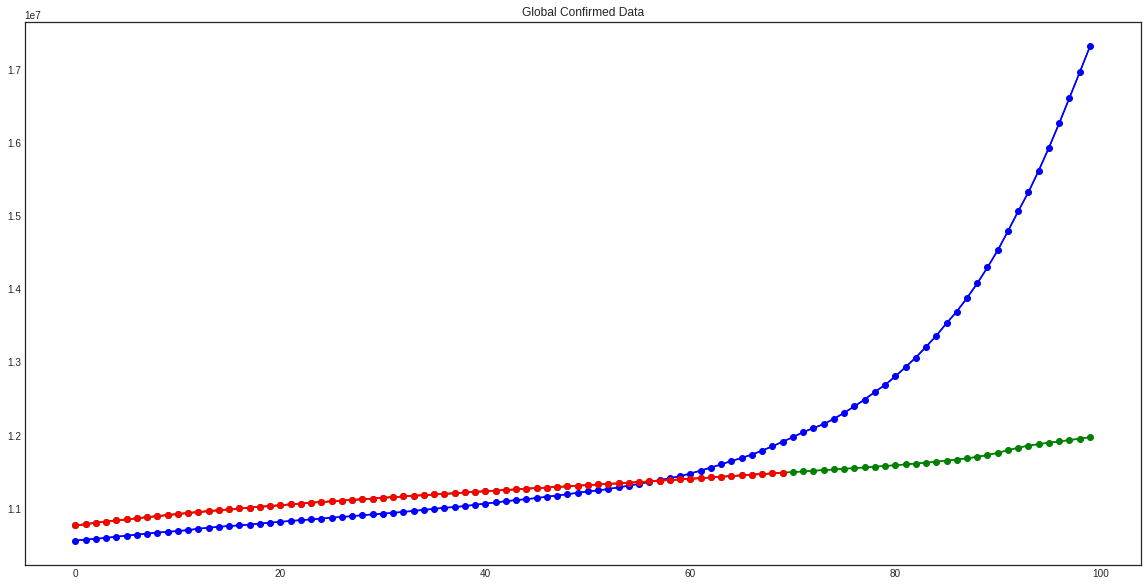

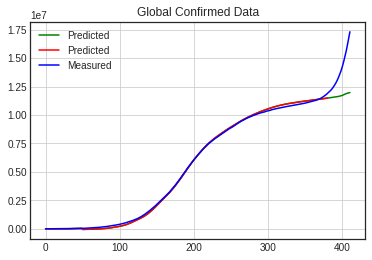

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  2.84s | mse loss 0.28596 | rmsle loss 0.20811 
-----------------------------------------------------------------------------------------
| epoch 181 |     1/    6 batches | lr 0.000000 | 76.59 ms | loss 0.00192 | ppl     1.00
| epoch 181 |     2/    6 batches | lr 0.000000 | 23.77 ms | loss 0.00108 | ppl     1.00
| epoch 181 |     3/    6 batches | lr 0.000000 | 29.38 ms | loss 0.00222 | ppl     1.00
| epoch 181 |     4/    6 batches | lr 0.000000 | 24.02 ms | loss 0.00098 | ppl     1.00
| epoch 181 |     5/    6 batches | lr 0.000000 | 24.14 ms | loss 0.00101 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 181 |     6/    6 batches | lr 0.000000 | 33.73 ms | loss 0.00241 | ppl     1.00
| epoch 182 |     1/    6 batches | lr 0.000000 | 48.37 ms | loss 0.00148 | ppl     1.00
| epoch 182 |     2/    6 batches | lr 0.000000 | 24.39 ms | loss 0.00136 | ppl     1.00
| epoch 182 |     3/    6 batches | lr 0.000000 | 28.73 ms | loss 0.00209 | ppl     1.00
| epoch 182 |     4/    6 batches | lr 0.000000 | 31.48 ms | loss 0.00072 | ppl     1.00
| epoch 182 |     5/    6 batches | lr 0.000000 | 24.15 ms | loss 0.00069 | ppl     1.00
| epoch 182 |     6/    6 batches | lr 0.000000 | 22.48 ms | loss 0.00219 | ppl     1.00
| epoch 183 |     1/    6 batches | lr 0.000000 | 49.43 ms | loss 0.00209 | ppl     1.00
| epoch 183 |     2/    6 batches | lr 0.000000 | 33.08 ms | loss 0.00124 | ppl     1.00
| epoch 183 |     3/    6 batches | lr 0.000000 | 24.25 ms | loss 0.00214 | ppl     1.00
| epoch 183 |     4/    6 batches | lr 0.000000 | 24.14 ms | loss 0.00089 | ppl     1.00
| epoch 183 |     5/ 

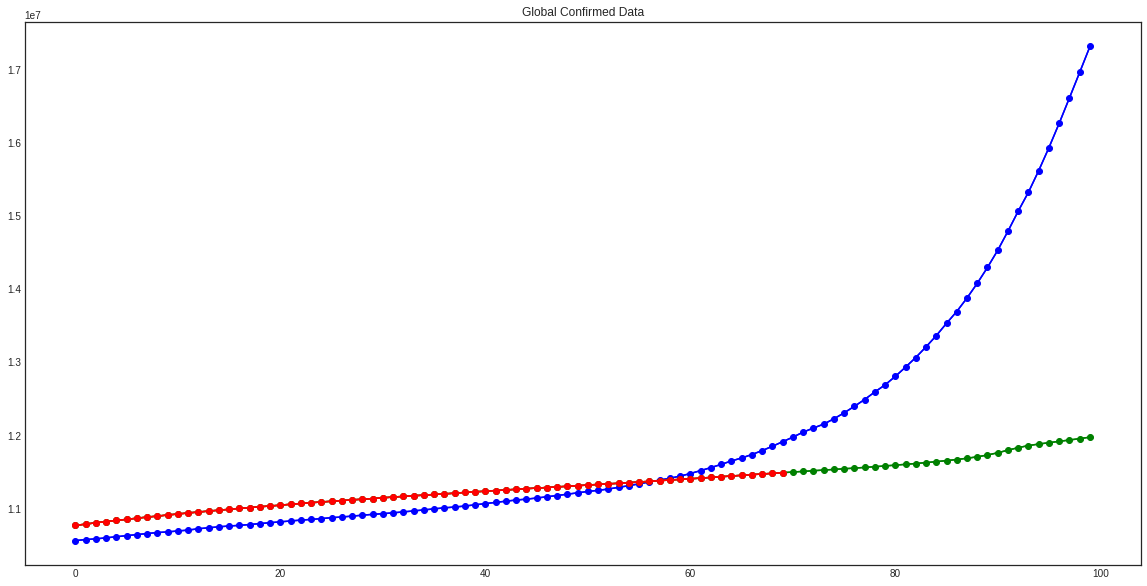

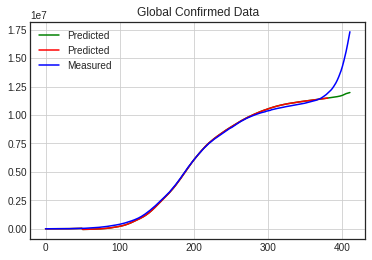

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  2.75s | mse loss 0.28586 | rmsle loss 0.20807 
-----------------------------------------------------------------------------------------
| epoch 191 |     1/    6 batches | lr 0.000000 | 49.34 ms | loss 0.00223 | ppl     1.00
| epoch 191 |     2/    6 batches | lr 0.000000 | 25.76 ms | loss 0.00161 | ppl     1.00
| epoch 191 |     3/    6 batches | lr 0.000000 | 39.30 ms | loss 0.00192 | ppl     1.00
| epoch 191 |     4/    6 batches | lr 0.000000 | 29.58 ms | loss 0.00085 | ppl     1.00
| epoch 191 |     5/    6 batches | lr 0.000000 | 24.05 ms | loss 0.00066 | ppl     1.00
| epoch 191 |     6/    6 batches | lr 0.000000 | 22.60 ms | loss 0.00236 | ppl     1.00


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 192 |     1/    6 batches | lr 0.000000 | 50.88 ms | loss 0.00239 | ppl     1.00
| epoch 192 |     2/    6 batches | lr 0.000000 | 33.97 ms | loss 0.00158 | ppl     1.00
| epoch 192 |     3/    6 batches | lr 0.000000 | 65.32 ms | loss 0.00175 | ppl     1.00
| epoch 192 |     4/    6 batches | lr 0.000000 | 25.18 ms | loss 0.00071 | ppl     1.00
| epoch 192 |     5/    6 batches | lr 0.000000 | 25.97 ms | loss 0.00069 | ppl     1.00
| epoch 192 |     6/    6 batches | lr 0.000000 | 32.74 ms | loss 0.00241 | ppl     1.00
| epoch 193 |     1/    6 batches | lr 0.000000 | 51.77 ms | loss 0.00201 | ppl     1.00
| epoch 193 |     2/    6 batches | lr 0.000000 | 26.21 ms | loss 0.00114 | ppl     1.00
| epoch 193 |     3/    6 batches | lr 0.000000 | 26.23 ms | loss 0.00272 | ppl     1.00
| epoch 193 |     4/    6 batches | lr 0.000000 | 25.94 ms | loss 0.00087 | ppl     1.00
| epoch 193 |     5/    6 batches | lr 0.000000 | 31.82 ms | loss 0.00079 | ppl     1.00
| epoch 193 |     6/ 

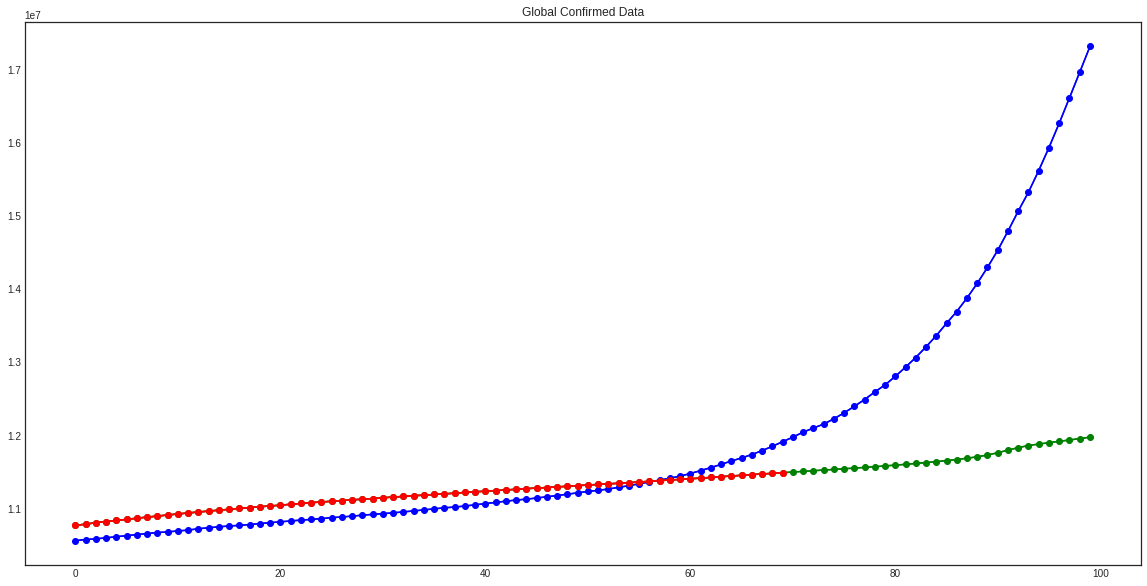

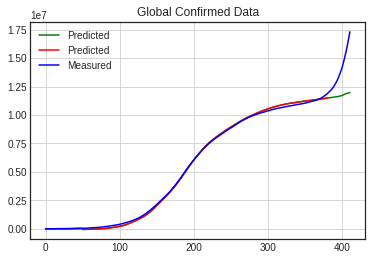

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  3.14s | mse loss 0.28583 | rmsle loss 0.20805 
-----------------------------------------------------------------------------------------


In [81]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/India.csv")
train_data, val_data = dealData.trainTestData()
# train_data = dealData.train_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % 10 is 0):
#         mse, rmsle, truth, test_result = dealData.get_plot_data(model)
#         plot_image(truth, test_result)
        mse, rmsle = dealData.plot_and_loss(model, epoch, True)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | mse loss {:5.5f} | rmsle loss {:5.5f} '.format(epoch, (time.time() - epoch_start_time),
                                         mse, rmsle))
        print('-' * 89)

    scheduler.step() 
#     saveModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best") 

In [82]:
saveModel(model, "parameter_india_confirmed_50sq_del30_NoGan_best") 

# Load Model

460 460
mse:  0.00035487188
rmsle:  0.006590831
mae:  0.014776715
mape:  0.0077972165
rmse:  0.018838044


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



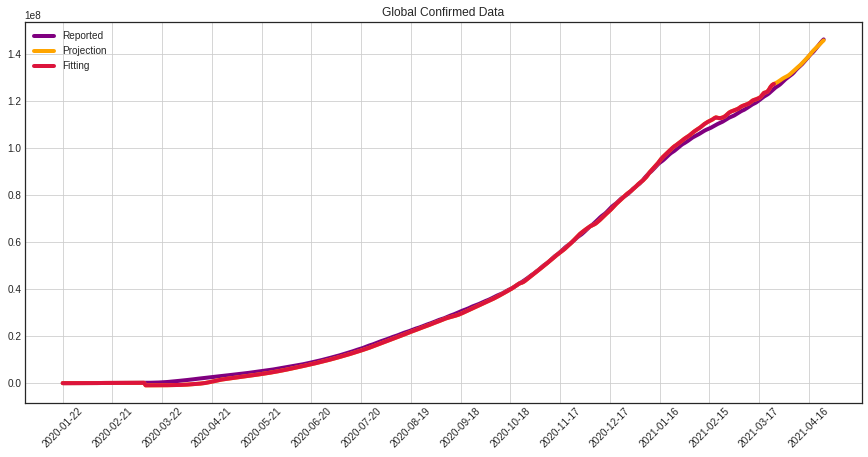

In [13]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Confirmed Data', isSave = False)

460 460
mse:  0.0033011897
rmsle:  0.018757403
mae:  0.049088575
mape:  0.024291454
rmse:  0.05745598


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



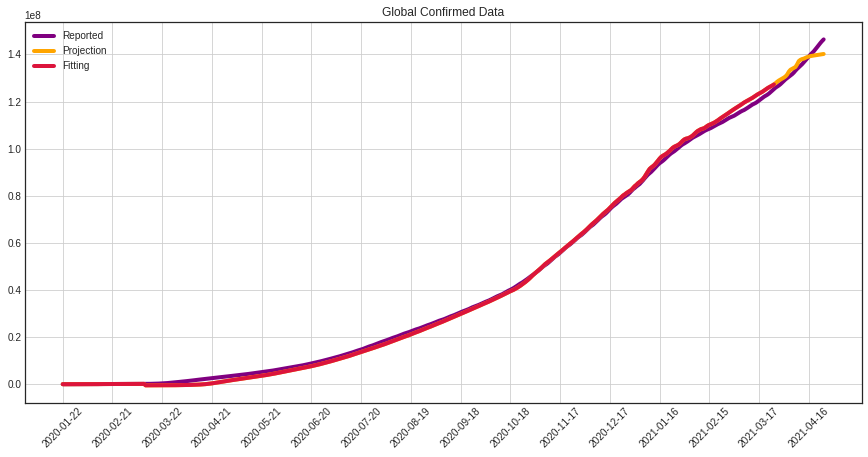

In [14]:
## sj noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_SJ_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_SJ_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Confirmed Data', isSave = False)

460 460
mse:  0.08541011
rmsle:  0.1003834
mae:  0.26767623
mape:  0.13101974
rmse:  0.2922501


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



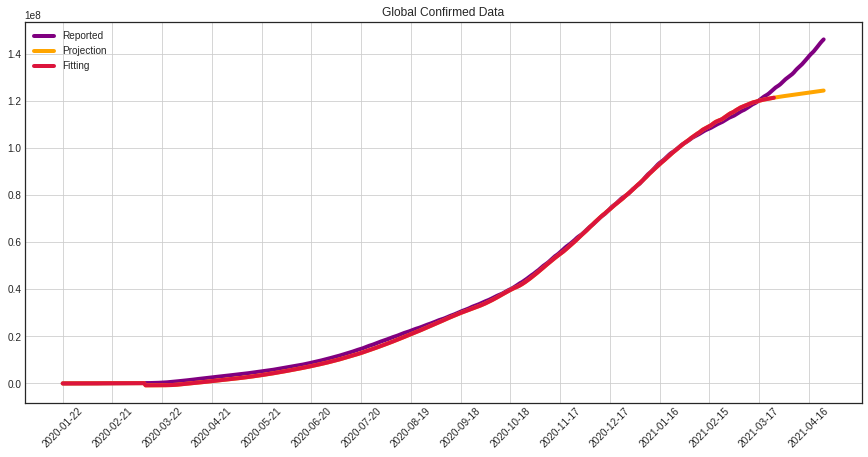

In [15]:
## no gan

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_NoGan_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Confirmed Data', isSave = False)

# global 

460 460
mse:  0.00035487188
rmsle:  0.006590831
mae:  0.014776715
mape:  0.0077972165
rmse:  0.018838044
2020-01-22 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



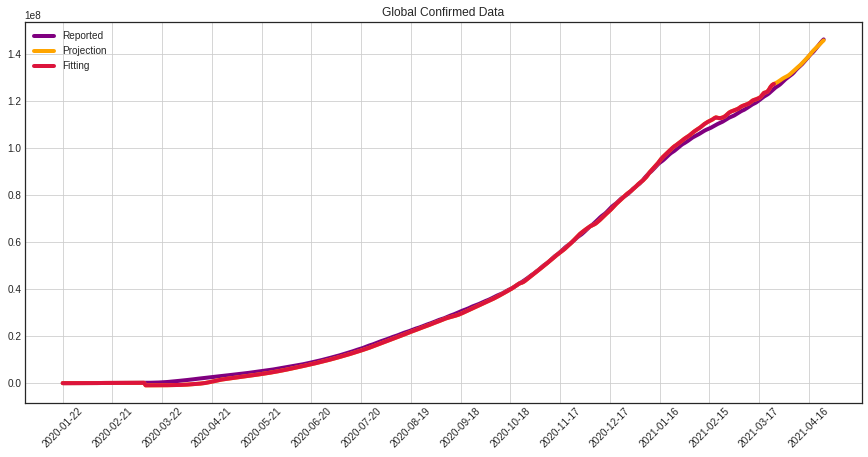

In [16]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Confirmed Data', isSave = True)

## Us

422 422
mse:  0.00032944494
rmsle:  0.0066318335
mae:  0.0150020365
mape:  0.008611545
rmse:  0.018150618
2020-02-29 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



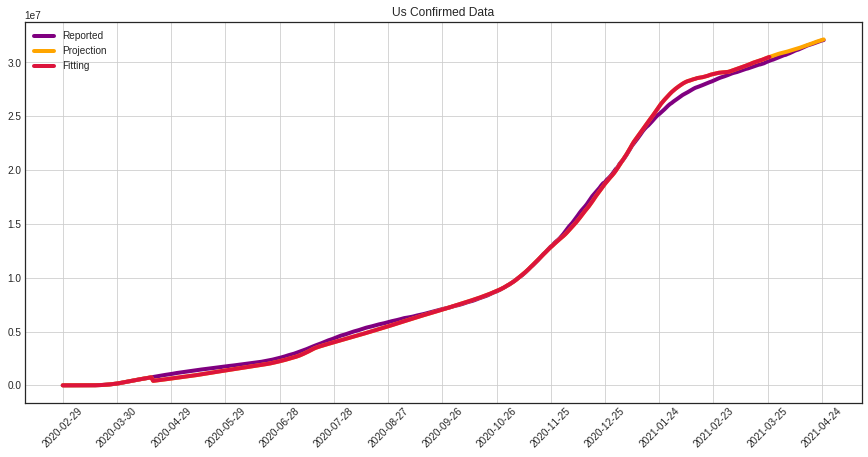

In [17]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_us_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/us.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_us_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/us.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Us Confirmed Data', isSave = True)

# Japan 

438 438
mse:  0.0023742977
rmsle:  0.015778456
mae:  0.038716804
mape:  0.019001232
rmse:  0.048726767
2020-02-13 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



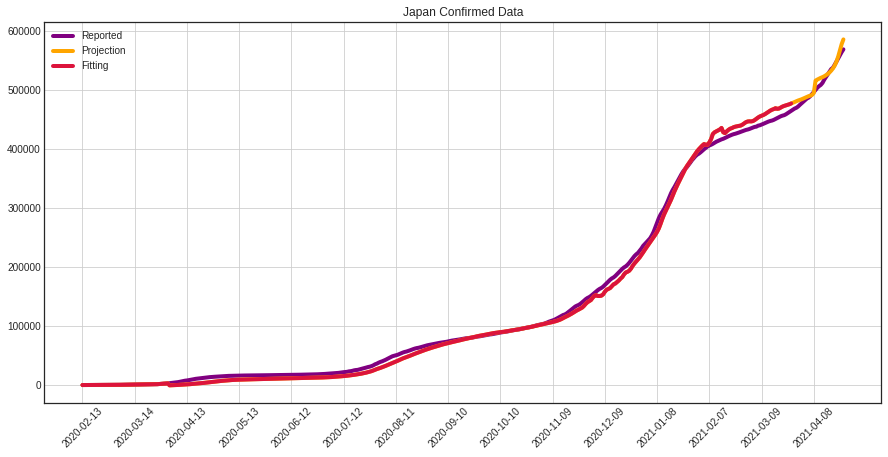

In [18]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_japan_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/japan.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_japan_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/japan.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Japan Confirmed Data', isSave = True)

# Spain 

419 419
mse:  0.0008263359
rmsle:  0.010215797
mae:  0.025116574
mape:  0.01388742
rmse:  0.02874606
2020-03-03 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



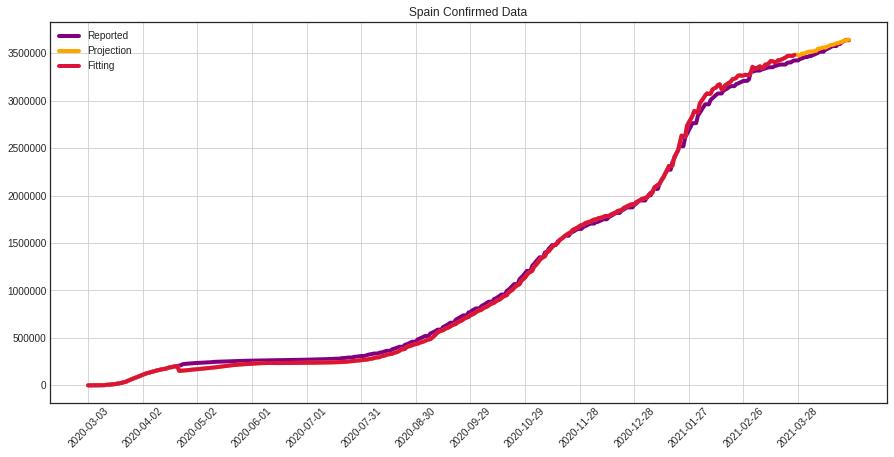

In [19]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_spain_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/spain.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_spain_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/spain.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Confirmed Data', isSave = True)

## France

436 436
mse:  0.0018272734
rmsle:  0.014184905
mae:  0.03541718
mape:  0.017498516
rmse:  0.04274662
2020-02-15 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



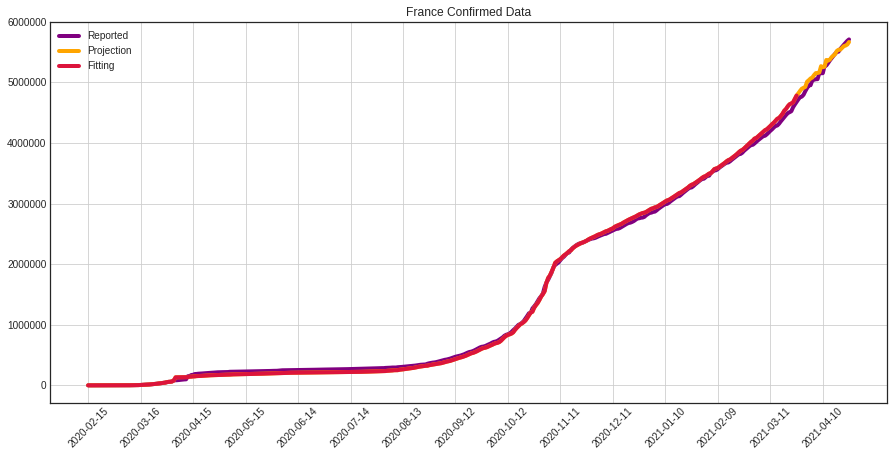

In [20]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_france_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/france.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_france_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/france.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'France Confirmed Data', isSave = True)

# Italy

430 430
mse:  0.0035856066
rmsle:  0.019216115
mae:  0.05539371
mape:  0.026139764
rmse:  0.059879936
2020-02-21 2021-04-25


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



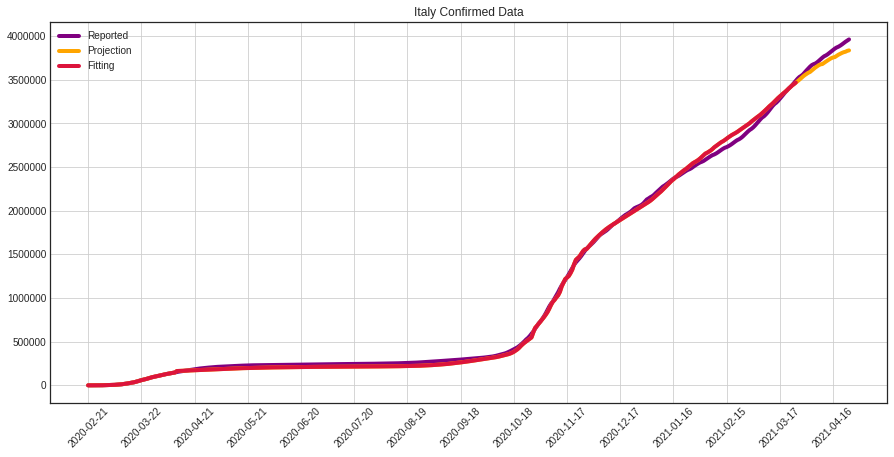

In [21]:
## noise

pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_italy_confirmed_50sq_del30_noise_best")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/italy.csv", 
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_italy_del30_confirmed_noise_1000.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/italy.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
print(df.date[0], df.date[df.shape[0]-1])
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Italy Confirmed Data', isSave = True)

/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  51 |     3/   17 batches | lr 0.000365 | 83.33 ms | loss 5.26437 | ppl   193.33
| epoch  51 |     6/   17 batches | lr 0.000365 | 42.70 ms | loss 6.61860 | ppl   748.89
| epoch  51 |     9/   17 batches | lr 0.000365 | 37.60 ms | loss 2.87187 | ppl    17.67
| epoch  51 |    12/   17 batches | lr 0.000365 | 46.00 ms | loss 1.29230 | ppl     3.64
| epoch  51 |    15/   17 batches | lr 0.000365 | 40.16 ms | loss 0.64047 | ppl     1.90
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.22 ms | loss 7.73861 | ppl  2295.27


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


| epoch  51 |     6/   17 batches | lr 0.000365 | 26.65 ms | loss 0.92826 | ppl     2.53
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.64 ms | loss 0.21502 | ppl     1.24
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.34 ms | loss 0.13884 | ppl     1.15
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.30 ms | loss 0.10222 | ppl     1.11
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.93 ms | loss 0.50497 | ppl     1.66
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.41 ms | loss 0.58922 | ppl     1.80
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.19 ms | loss 0.13834 | ppl     1.15
| epoch  51 |    12/   17 batches | lr 0.000365 | 25.86 ms | loss 0.14740 | ppl     1.16
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.32 ms | loss 0.25433 | ppl     1.29
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.97 ms | loss 0.49599 | ppl     1.64
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.48 ms | loss 0.09526 | ppl     1.10
| epoch  51 |     9/ 

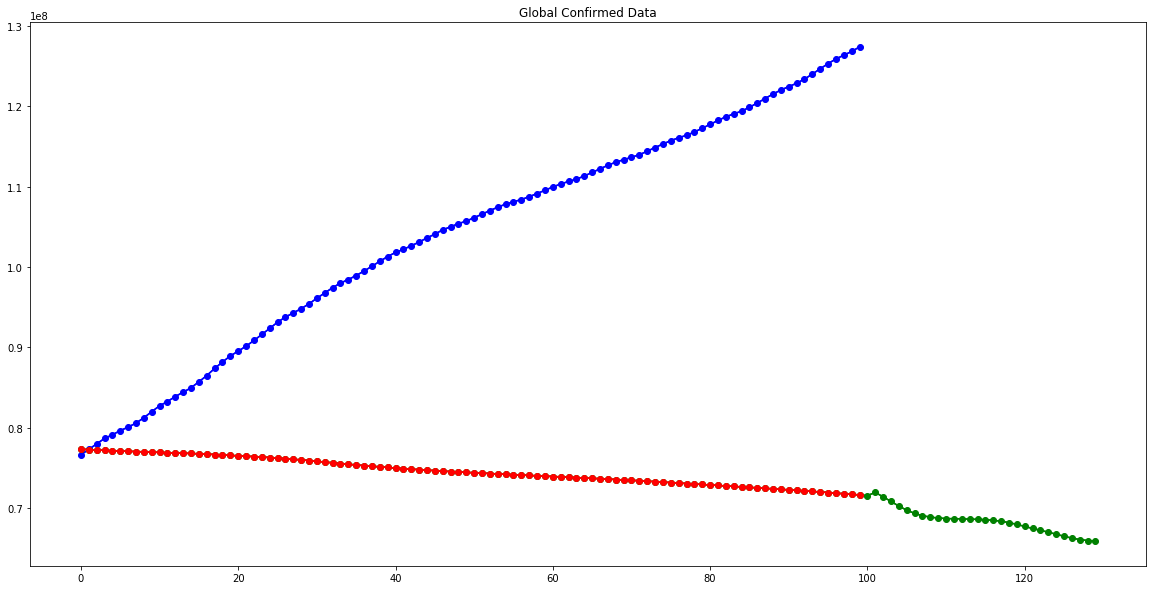

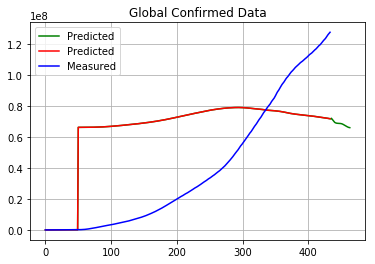

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  3.73s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.49 ms | loss 0.14856 | ppl     1.16
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.56 ms | loss 0.04299 | ppl     1.04
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.14 ms | loss 0.21668 | ppl     1.24
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.24 ms | loss 0.14269 | ppl     1.15
| epoch  51 |    15/   17 batches | lr 0.000365 | 27.50 ms | loss 0.22474 | ppl     1.25
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.20 ms | loss 0.32074 | ppl     1.38
| epoch  51 |     6/   17 batches | lr 0.000365 | 32.93 ms | loss 0.01219 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.56 ms | loss 0.15441 | ppl     1.17
| epoch  51 |    12/   17 batche

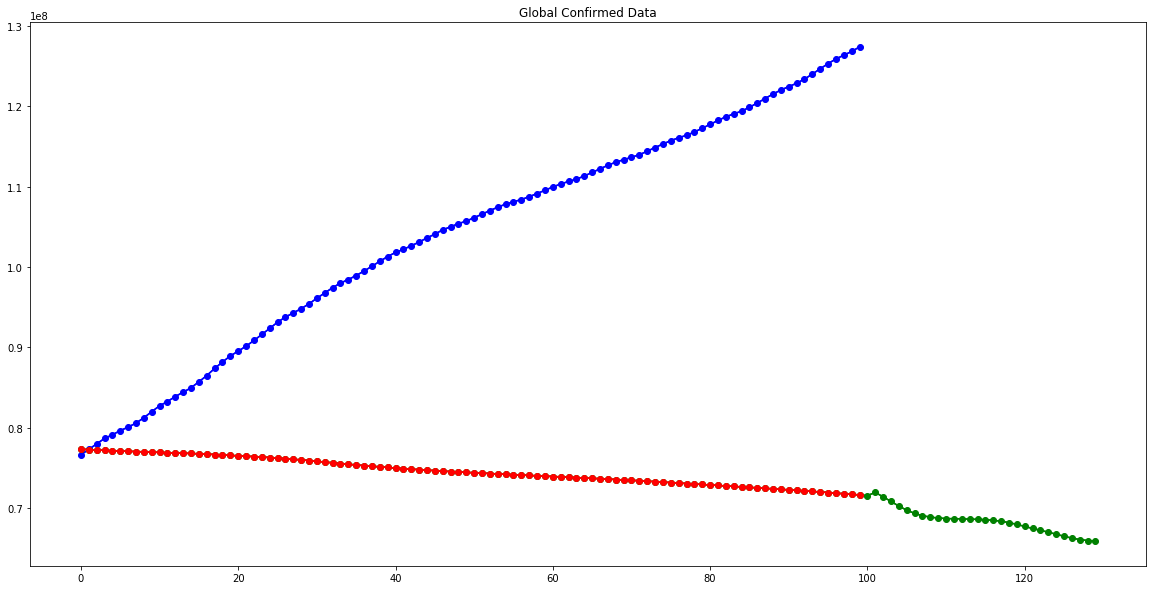

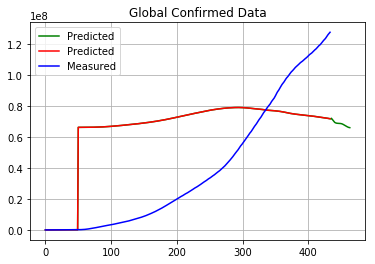

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  4.00s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.83 ms | loss 0.10920 | ppl     1.12
| epoch  51 |     6/   17 batches | lr 0.000365 | 25.95 ms | loss 0.01528 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.40 ms | loss 0.01177 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 25.48 ms | loss 0.00584 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.01 ms | loss 0.00882 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.89 ms | loss 0.09673 | ppl     1.10
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.34 ms | loss 0.02279 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.18 ms | loss 0.00680 | ppl     1.01
| epoch  51 |    12/   17 batche

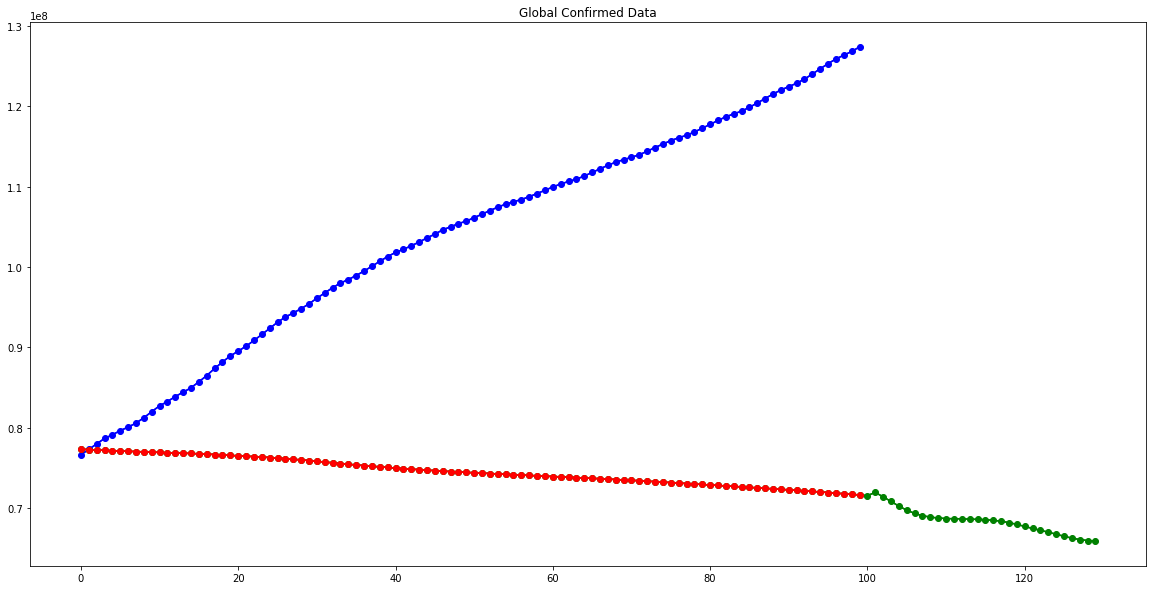

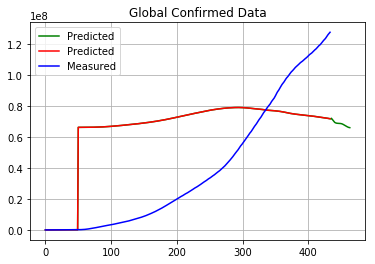

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  3.74s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 40.50 ms | loss 0.56228 | ppl     1.75
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.53 ms | loss 0.11174 | ppl     1.12
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.88 ms | loss 0.03965 | ppl     1.04
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.15 ms | loss 0.04506 | ppl     1.05
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.28 ms | loss 0.02923 | ppl     1.03
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.85 ms | loss 0.08863 | ppl     1.09
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.45 ms | loss 0.03941 | ppl     1.04
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.44 ms | loss 0.04359 | ppl     1.04
| epoch  51 |    12/   17 batche

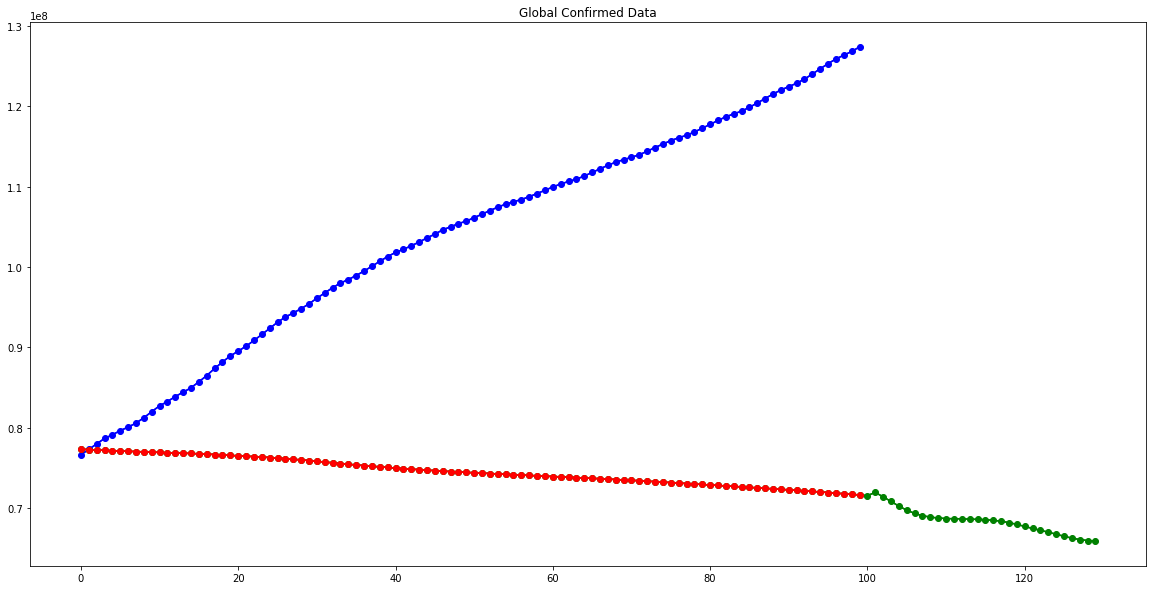

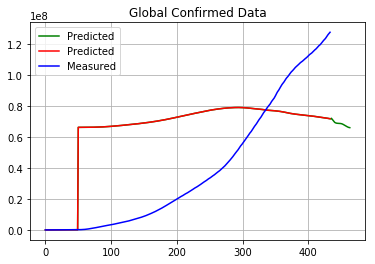

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  4.32s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.23 ms | loss 0.02504 | ppl     1.03
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.58 ms | loss 0.00990 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.95 ms | loss 0.01416 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.56 ms | loss 0.00692 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.39 ms | loss 0.00723 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.47 ms | loss 0.07906 | ppl     1.08
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.47 ms | loss 0.01157 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.18 ms | loss 0.00896 | ppl     1.01
| epoch  51 |    12/   17 batche

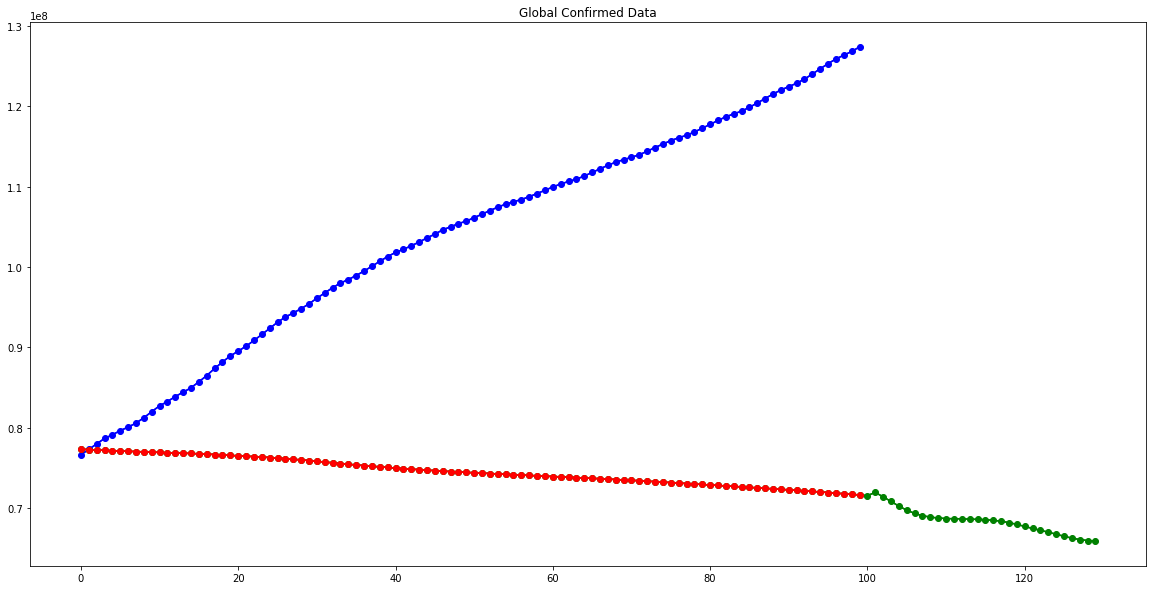

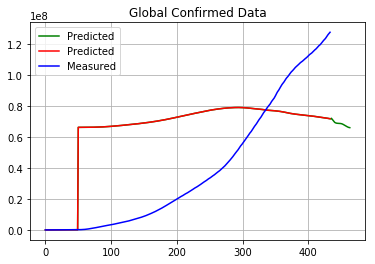

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  3.98s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.91 ms | loss 0.10744 | ppl     1.11
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.47 ms | loss 0.02833 | ppl     1.03
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.35 ms | loss 0.01984 | ppl     1.02
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.61 ms | loss 0.00615 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.26 ms | loss 0.00829 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.43 ms | loss 0.02504 | ppl     1.03
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.46 ms | loss 0.02644 | ppl     1.03
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.70 ms | loss 0.01831 | ppl     1.02
| epoch  51 |    12/   17 batche

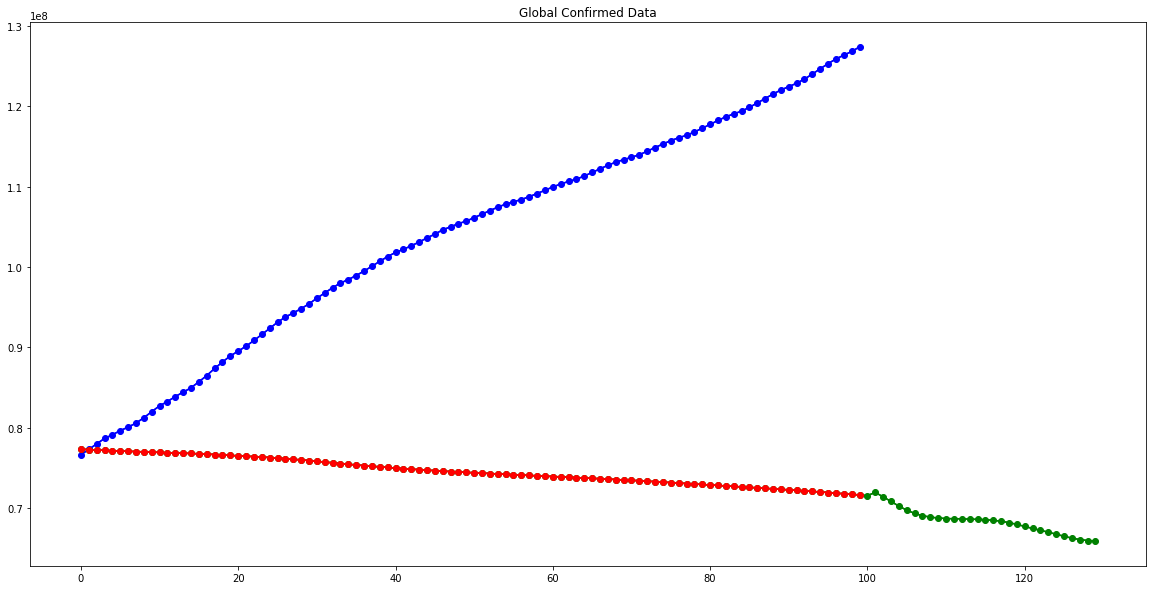

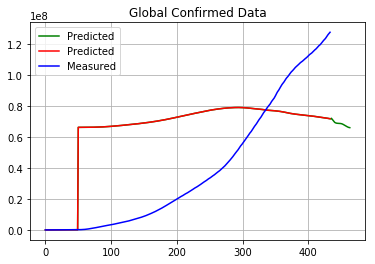

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  4.08s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.10 ms | loss 0.01473 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.84 ms | loss 0.00896 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.98 ms | loss 0.01912 | ppl     1.02
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.70 ms | loss 0.00916 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.65 ms | loss 0.00886 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.97 ms | loss 0.10150 | ppl     1.11
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.72 ms | loss 0.01041 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.77 ms | loss 0.00667 | ppl     1.01
| epoch  51 |    12/   17 batche

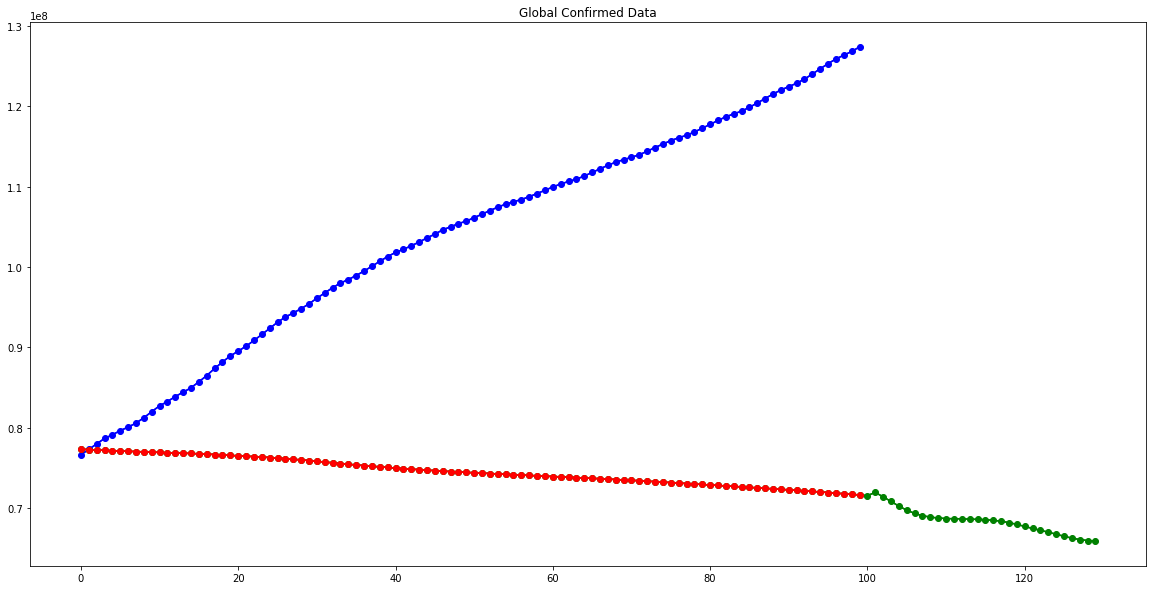

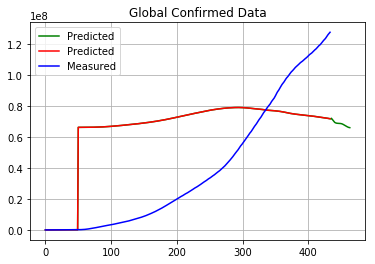

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  3.51s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.00 ms | loss 0.07099 | ppl     1.07
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.49 ms | loss 0.00666 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.72 ms | loss 0.02315 | ppl     1.02
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.95 ms | loss 0.00894 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.93 ms | loss 0.00627 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.66 ms | loss 0.06577 | ppl     1.07
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.16 ms | loss 0.02192 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.58 ms | loss 0.00737 | ppl     1.01
| epoch  51 |    12/   17 batche

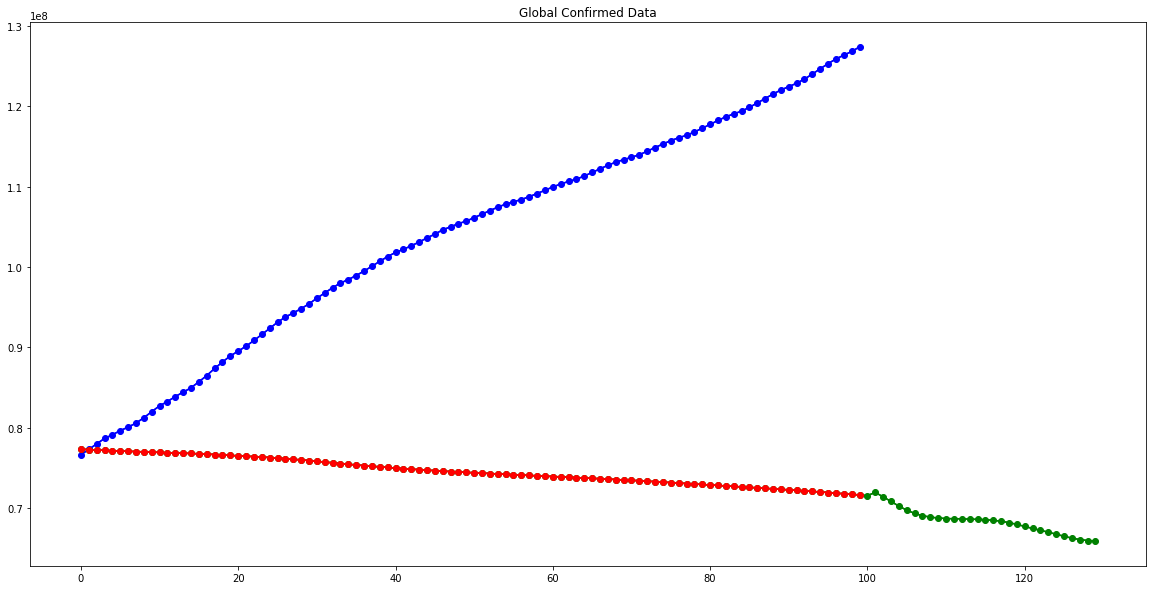

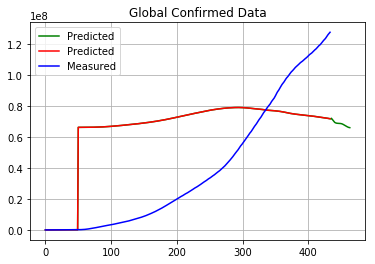

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  3.92s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.31 ms | loss 0.02509 | ppl     1.03
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.55 ms | loss 0.01291 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.81 ms | loss 0.00635 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.67 ms | loss 0.00887 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 27.58 ms | loss 0.00589 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.11 ms | loss 0.01742 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 28.52 ms | loss 0.02659 | ppl     1.03
| epoch  51 |     9/   17 batches | lr 0.000365 | 28.33 ms | loss 0.01137 | ppl     1.01
| epoch  51 |    12/   17 batche

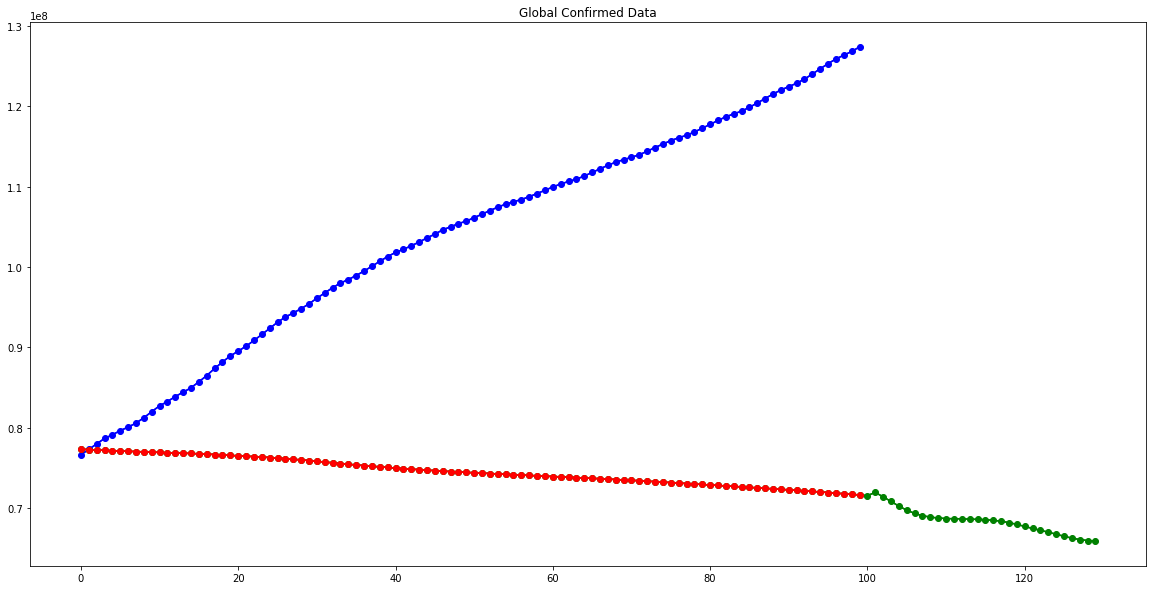

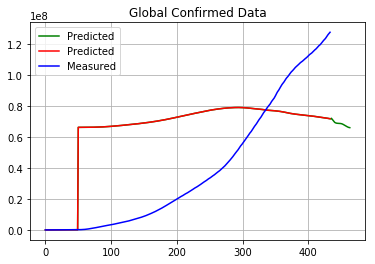

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  4.14s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 34.64 ms | loss 0.00749 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.30 ms | loss 0.02093 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.45 ms | loss 0.00703 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 27.80 ms | loss 0.01853 | ppl     1.02
| epoch  51 |    15/   17 batches | lr 0.000365 | 28.17 ms | loss 0.01014 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 38.86 ms | loss 0.06260 | ppl     1.06
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.84 ms | loss 0.00666 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 28.29 ms | loss 0.00776 | ppl     1.01
| epoch  51 |    12/   17 batche

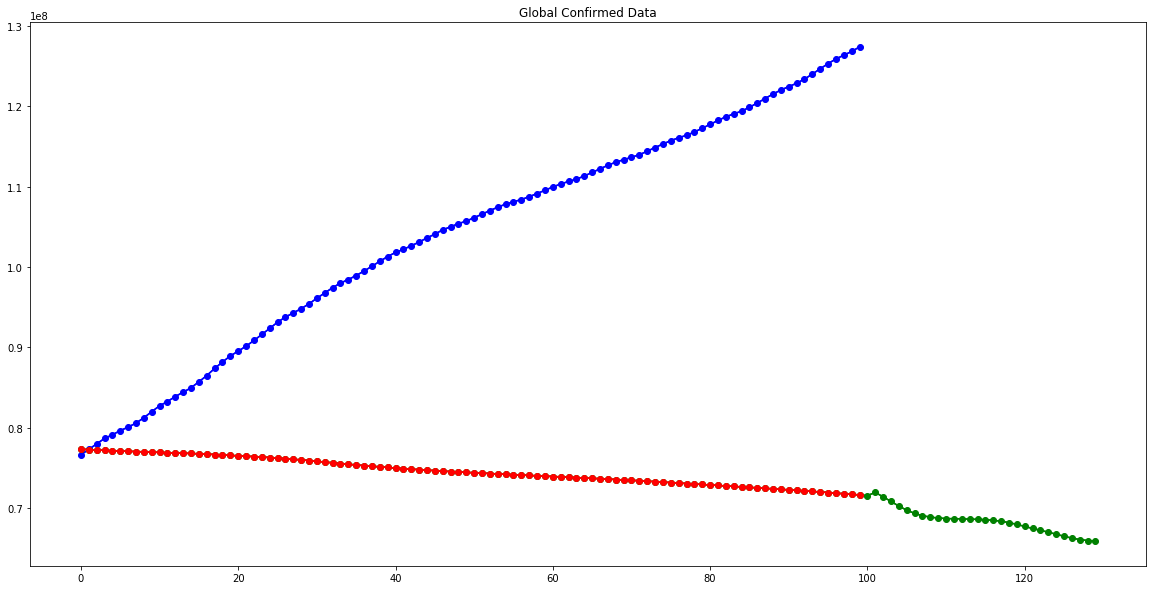

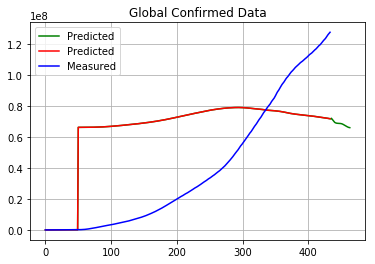

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  3.67s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.38 ms | loss 0.01343 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 28.00 ms | loss 0.02968 | ppl     1.03
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.86 ms | loss 0.03920 | ppl     1.04
| epoch  51 |    12/   17 batches | lr 0.000365 | 27.70 ms | loss 0.01917 | ppl     1.02
| epoch  51 |    15/   17 batches | lr 0.000365 | 28.87 ms | loss 0.04051 | ppl     1.04
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.39 ms | loss 0.04831 | ppl     1.05
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.75 ms | loss 0.01837 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 28.07 ms | loss 0.01005 | ppl     1.01
| epoch  51 |    12/   17 batche

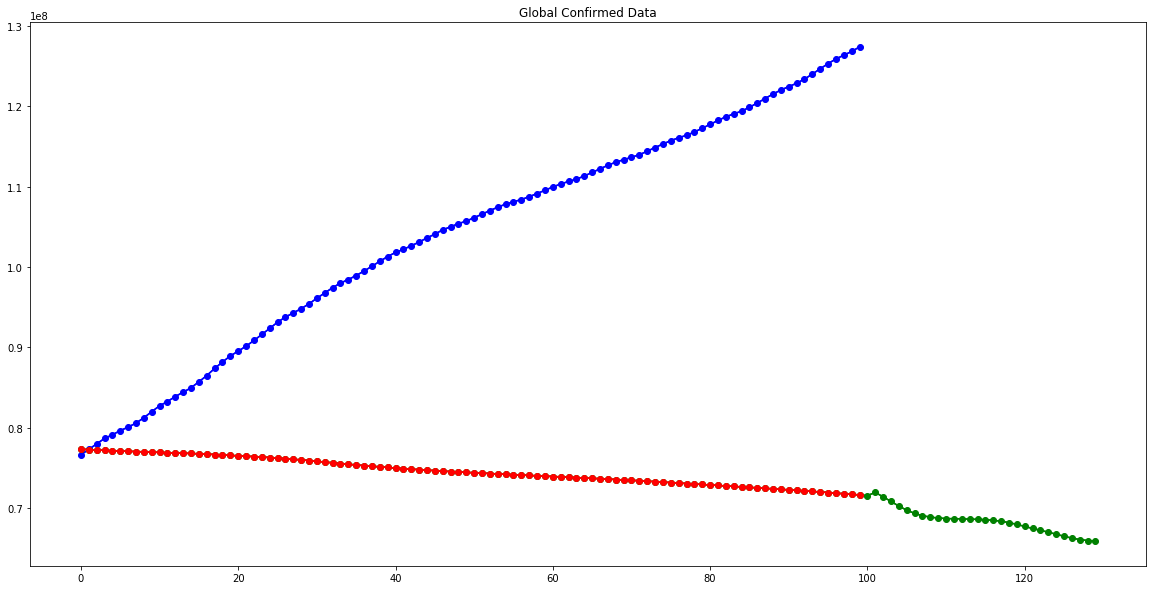

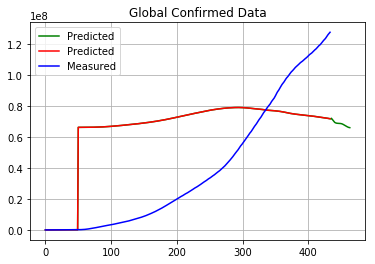

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  3.67s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.20 ms | loss 0.04194 | ppl     1.04
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.65 ms | loss 0.00578 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.79 ms | loss 0.00383 | ppl     1.00
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.53 ms | loss 0.00284 | ppl     1.00
| epoch  51 |    15/   17 batches | lr 0.000365 | 28.49 ms | loss 0.00225 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.97 ms | loss 0.01270 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 28.32 ms | loss 0.01568 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.89 ms | loss 0.00998 | ppl     1.01
| epoch  51 |    12/   17 batche

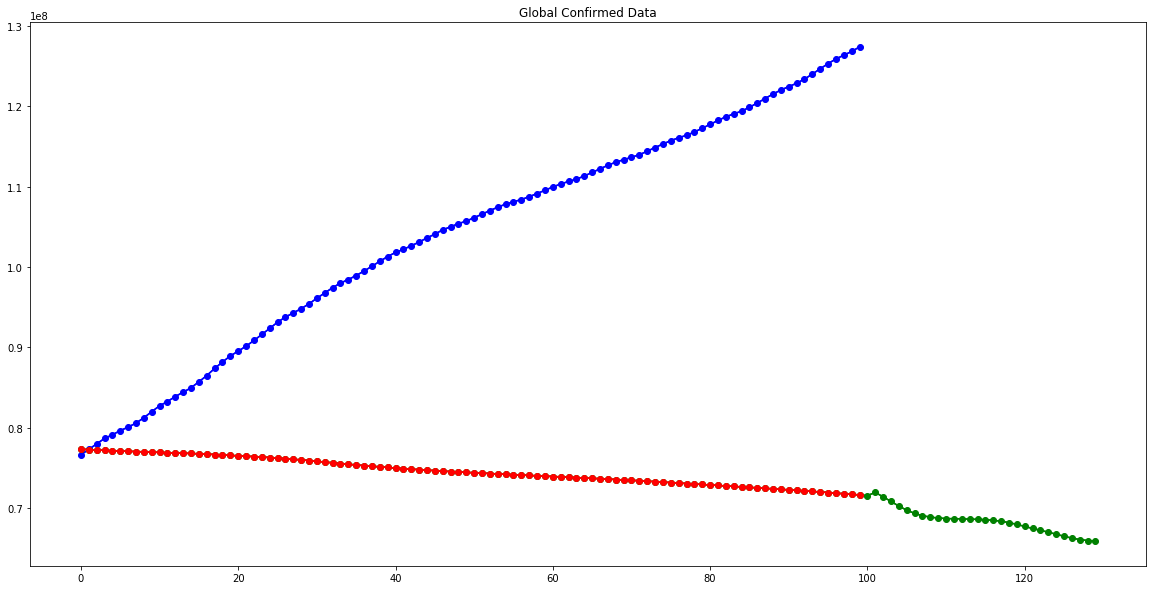

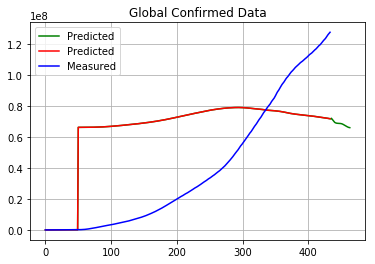

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  3.92s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.84 ms | loss 0.21814 | ppl     1.24
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.71 ms | loss 0.07342 | ppl     1.08
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.70 ms | loss 0.05094 | ppl     1.05
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.54 ms | loss 0.02122 | ppl     1.02
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.10 ms | loss 0.00551 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.46 ms | loss 0.08168 | ppl     1.09
| epoch  51 |     6/   17 batches | lr 0.000365 | 25.98 ms | loss 0.00839 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 25.94 ms | loss 0.01363 | ppl     1.01
| epoch  51 |    12/   17 batche

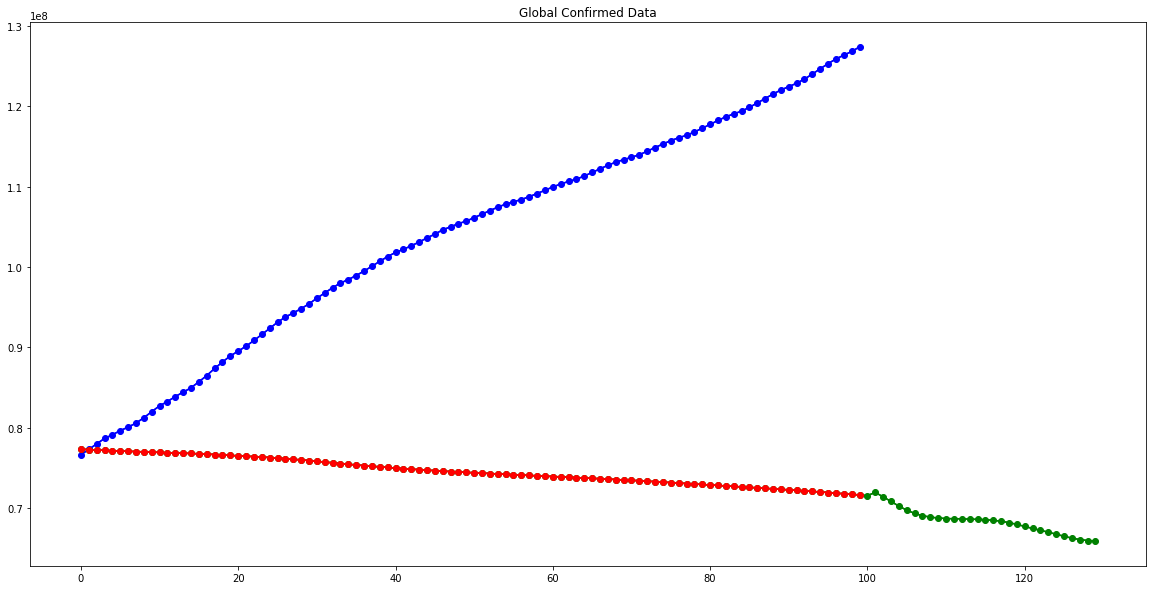

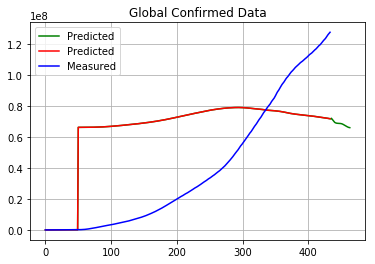

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  3.51s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 51.39 ms | loss 0.01992 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 43.16 ms | loss 0.01666 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 48.60 ms | loss 0.00479 | ppl     1.00
| epoch  51 |    12/   17 batches | lr 0.000365 | 48.33 ms | loss 0.00348 | ppl     1.00
| epoch  51 |    15/   17 batches | lr 0.000365 | 44.12 ms | loss 0.00367 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 107.16 ms | loss 0.00662 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 32.37 ms | loss 0.01369 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.15 ms | loss 0.01608 | ppl     1.02
| epoch  51 |    12/   17 batch

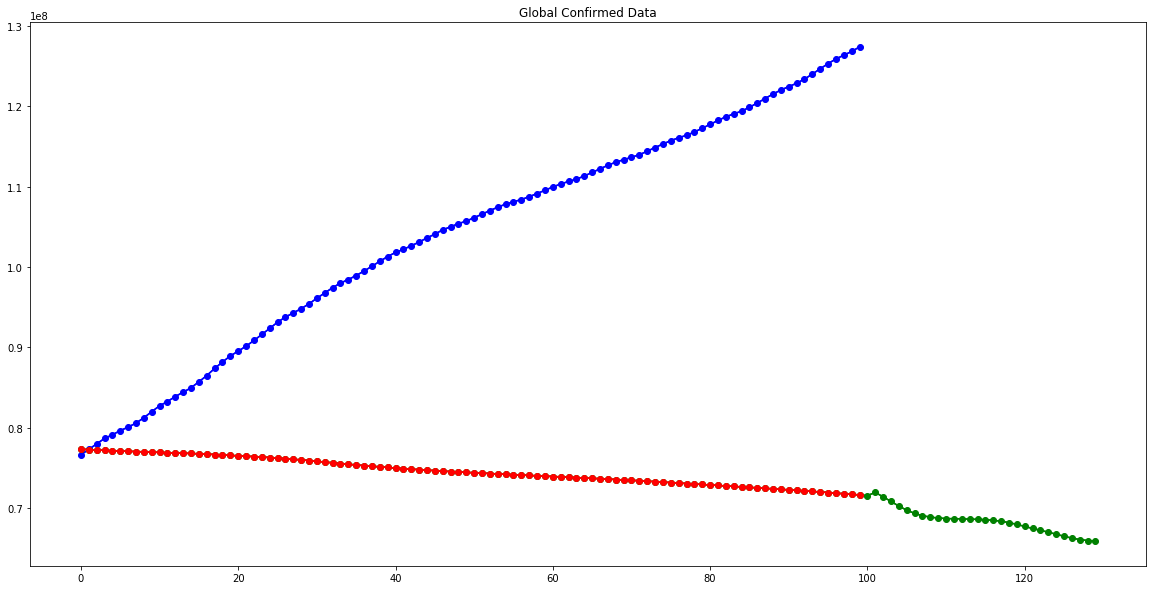

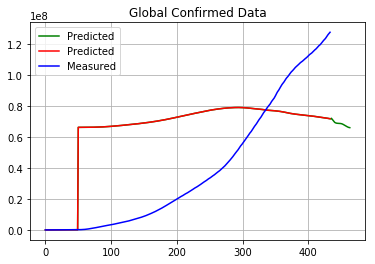

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  3.65s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.39 ms | loss 0.03607 | ppl     1.04
| epoch  51 |     6/   17 batches | lr 0.000365 | 25.70 ms | loss 0.00573 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.09 ms | loss 0.01329 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.02 ms | loss 0.00306 | ppl     1.00
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.06 ms | loss 0.00337 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.28 ms | loss 0.01504 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.00 ms | loss 0.01022 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 25.28 ms | loss 0.00679 | ppl     1.01
| epoch  51 |    12/   17 batche

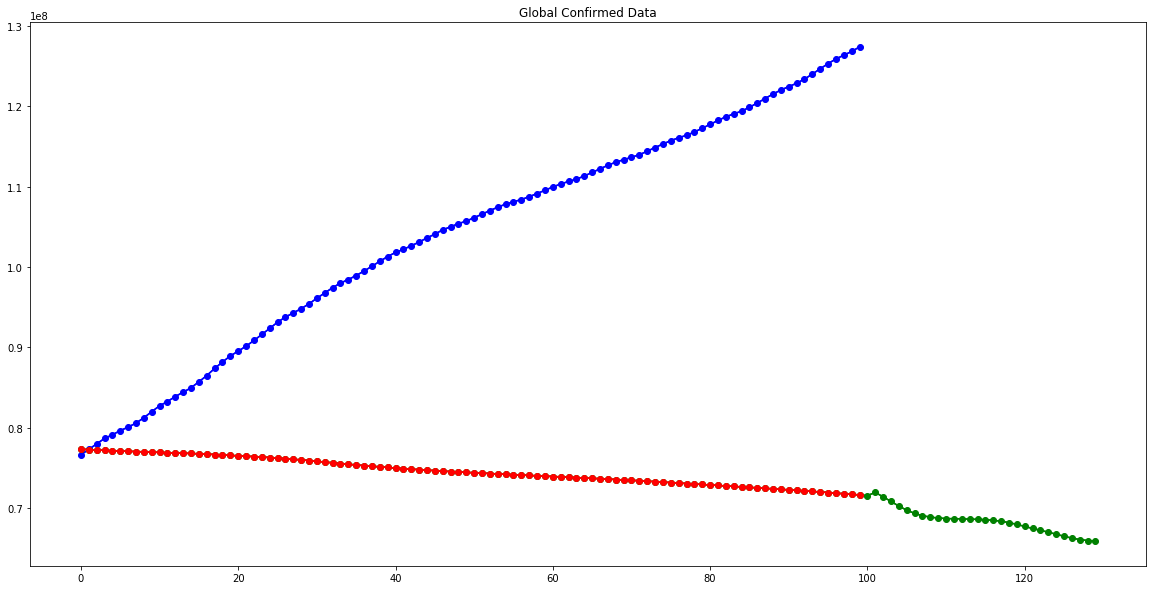

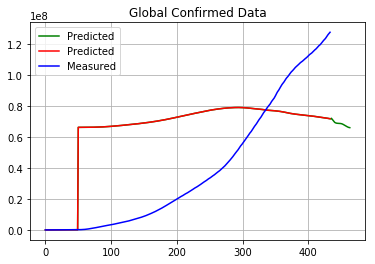

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  4.31s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.54 ms | loss 0.01841 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.46 ms | loss 0.00299 | ppl     1.00
| epoch  51 |     9/   17 batches | lr 0.000365 | 28.21 ms | loss 0.00502 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 27.69 ms | loss 0.00671 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 28.50 ms | loss 0.00440 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.88 ms | loss 0.02456 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.13 ms | loss 0.00327 | ppl     1.00
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.88 ms | loss 0.01014 | ppl     1.01
| epoch  51 |    12/   17 batche

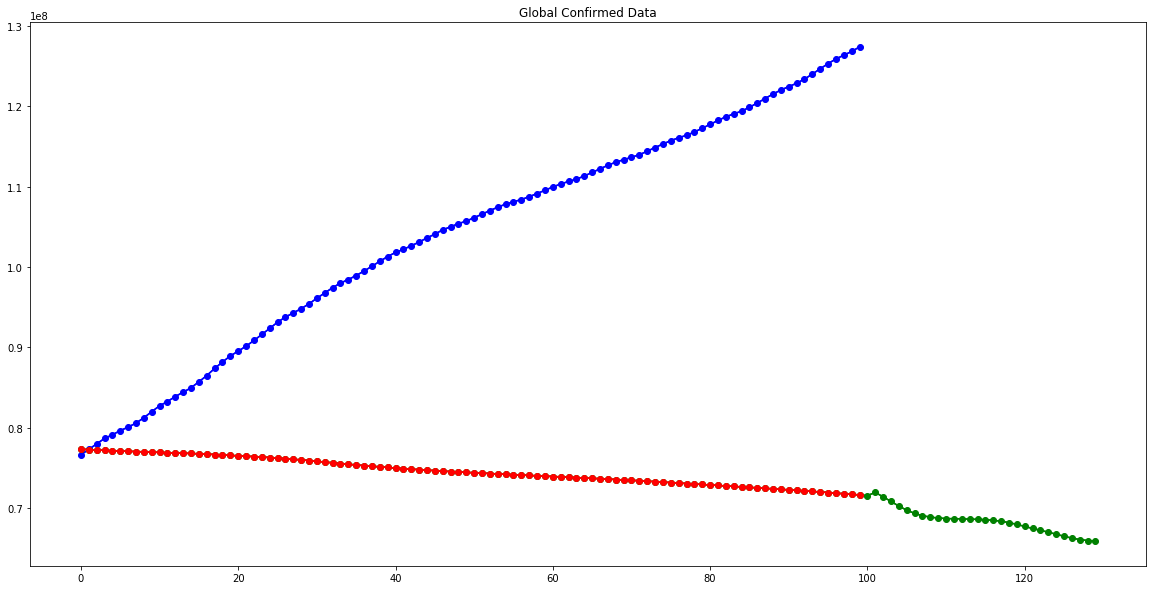

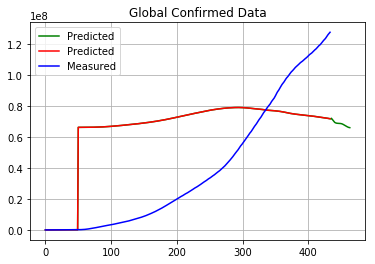

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  3.79s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 84.55 ms | loss 0.00888 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.39 ms | loss 0.02807 | ppl     1.03
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.91 ms | loss 0.01240 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 28.02 ms | loss 0.00850 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.51 ms | loss 0.00411 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 36.63 ms | loss 0.02074 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.74 ms | loss 0.00960 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.62 ms | loss 0.00725 | ppl     1.01
| epoch  51 |    12/   17 batche

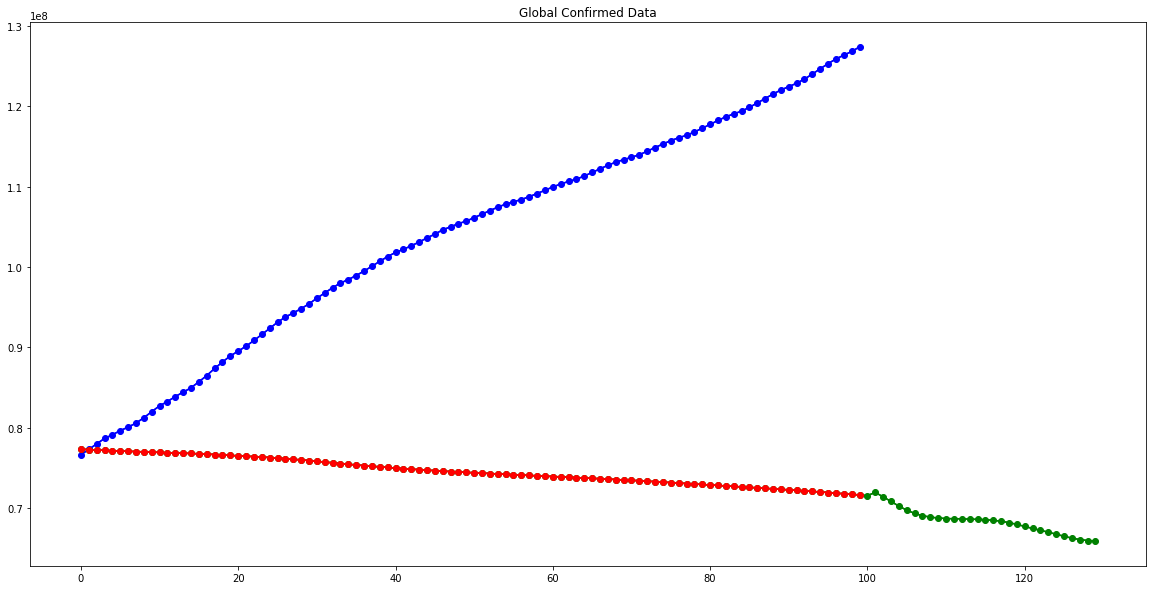

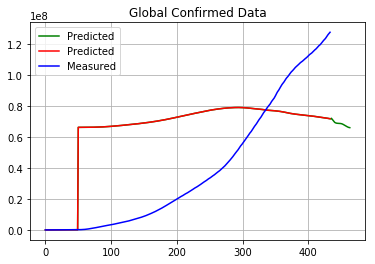

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  4.25s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.26 ms | loss 0.04188 | ppl     1.04
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.45 ms | loss 0.00767 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.05 ms | loss 0.01607 | ppl     1.02
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.62 ms | loss 0.00753 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.70 ms | loss 0.01102 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.18 ms | loss 0.02646 | ppl     1.03
| epoch  51 |     6/   17 batches | lr 0.000365 | 27.26 ms | loss 0.01224 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 50.89 ms | loss 0.02321 | ppl     1.02
| epoch  51 |    12/   17 batche

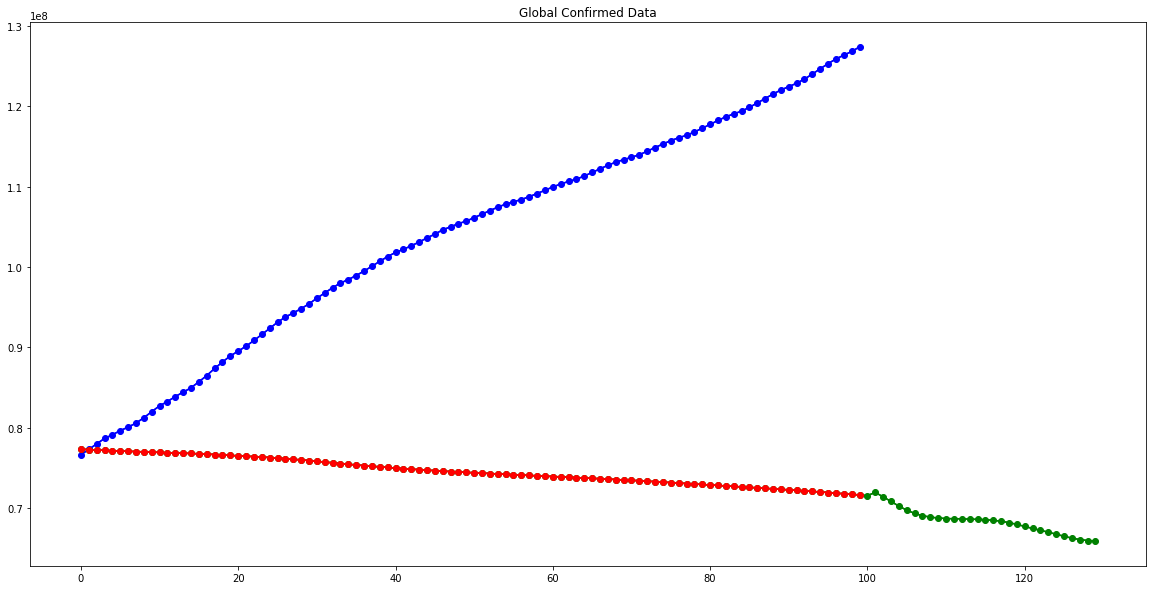

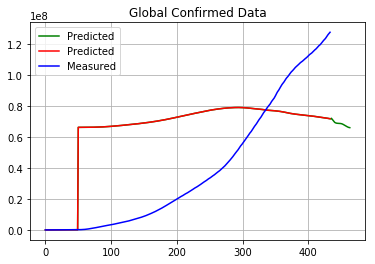

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  4.21s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 37.81 ms | loss 0.02411 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.50 ms | loss 0.00748 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.95 ms | loss 0.00558 | ppl     1.01
| epoch  51 |    12/   17 batches | lr 0.000365 | 26.44 ms | loss 0.00656 | ppl     1.01
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.04 ms | loss 0.00507 | ppl     1.01
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.43 ms | loss 0.01914 | ppl     1.02
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.58 ms | loss 0.01135 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 27.15 ms | loss 0.00664 | ppl     1.01
| epoch  51 |    12/   17 batche

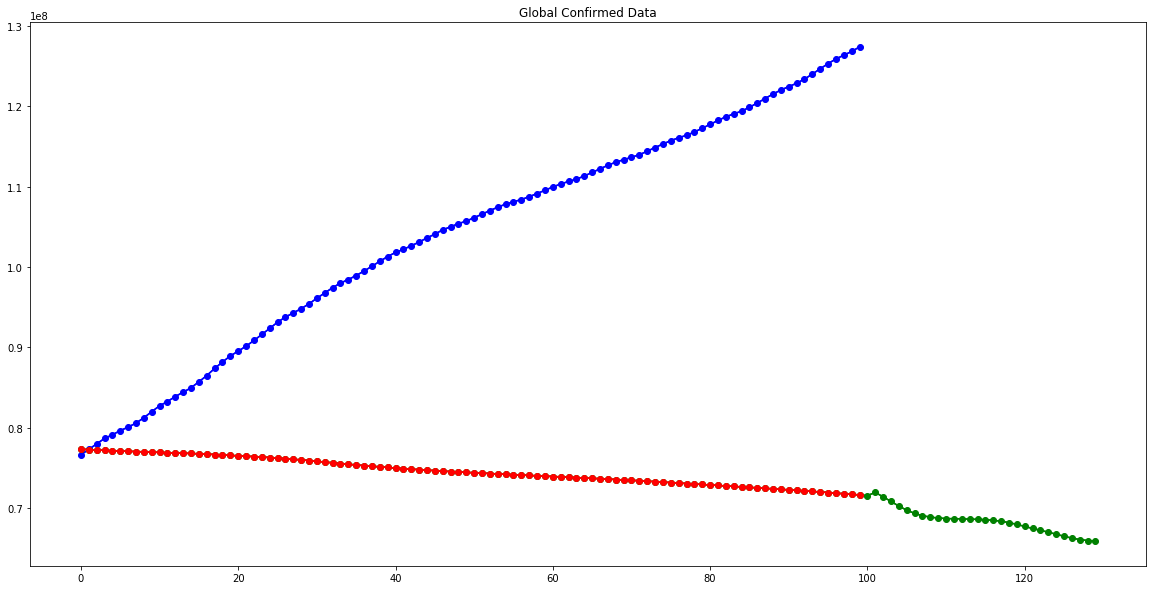

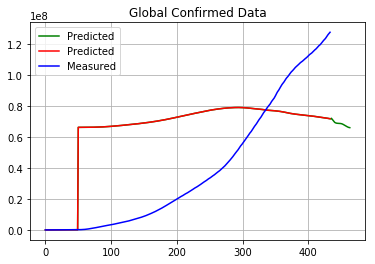

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  3.75s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.83 ms | loss 0.02732 | ppl     1.03
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.00 ms | loss 0.00912 | ppl     1.01
| epoch  51 |     9/   17 batches | lr 0.000365 | 25.98 ms | loss 0.01760 | ppl     1.02
| epoch  51 |    12/   17 batches | lr 0.000365 | 25.47 ms | loss 0.00306 | ppl     1.00
| epoch  51 |    15/   17 batches | lr 0.000365 | 26.63 ms | loss 0.00412 | ppl     1.00
| epoch  51 |     3/   17 batches | lr 0.000365 | 35.16 ms | loss 0.01162 | ppl     1.01
| epoch  51 |     6/   17 batches | lr 0.000365 | 26.49 ms | loss 0.01689 | ppl     1.02
| epoch  51 |     9/   17 batches | lr 0.000365 | 26.22 ms | loss 0.03403 | ppl     1.03
| epoch  51 |    12/   17 batche

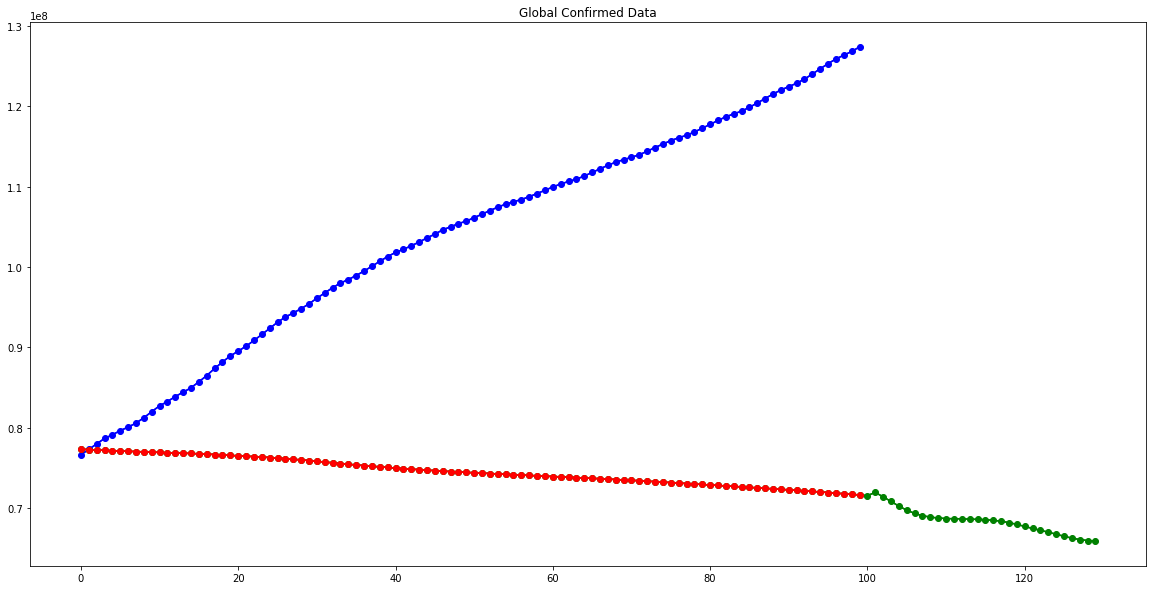

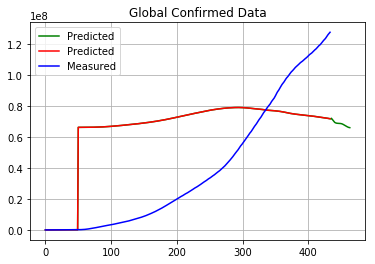

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  3.48s | valid loss 0.00072 | valid ppl     1.00
-----------------------------------------------------------------------------------------


In [746]:



#     modelName = "parameter_global_confirmed_50sq_del30_changeLoss_best"
    dealData = DealData() 
    train_data = dealData.trainPredictData()
    # train_data = dealData.train_data()
    model = TransAm().to(device)
#     model = loadModel(model, modelName)
#     dealData.plot_and_loss(model, 0)

    criterion = nn.MSELoss()
    lr = 0.005 
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    best_val_loss = float("inf")
    epochs = 200 # The number of epochs
    best_model = None

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(train_data)

        if(epoch % 10 is 0):
            mse, rmsle = dealData.plot_and_loss(model, epoch, True)
            print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | mse loss {:5.5f} | mse loss {:5.5f}'.format(epoch, (time.time() - epoch_start_time),
                                         mse, rmsle))
            print('-' * 89)

        scheduler.step() 
    saveModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_N_best")  
    

434 434


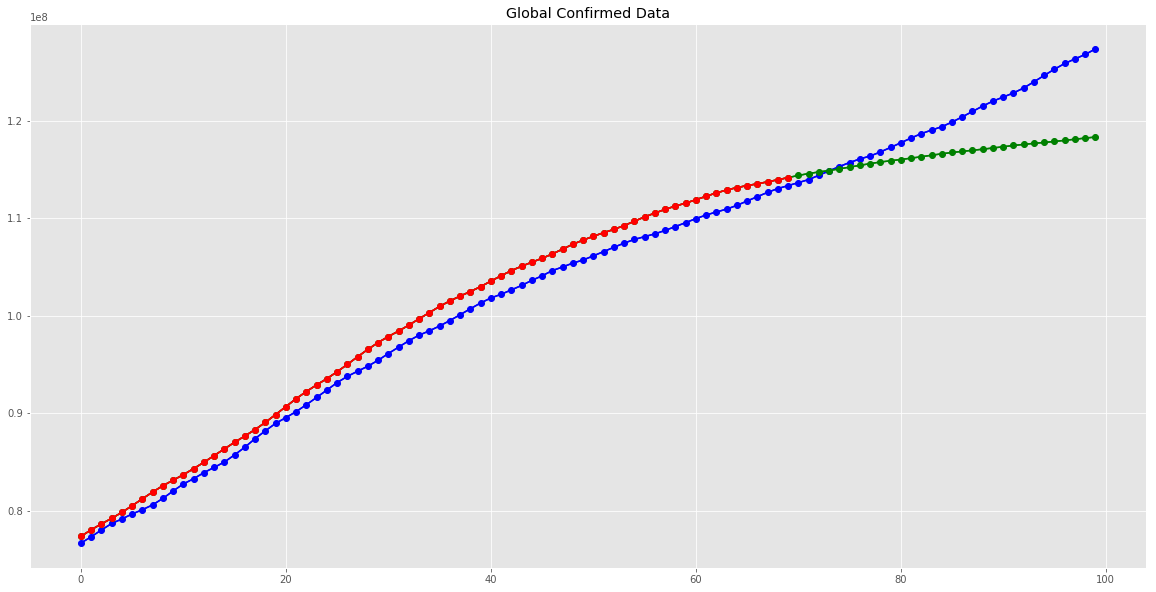

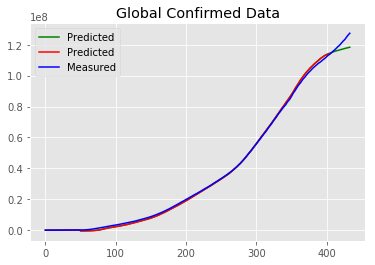

0.012769445776939392 0.03751805


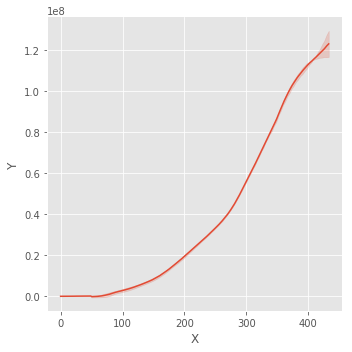

In [932]:
model = TransAm().to(device)
model = loadModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_nogan_best")
dealData = DealData()
mse, rmsle = dealData.plot_and_loss(model, 0, True)
print(mse, rmsle)
# saveModel(model, "parameter_global_confirmed_50sq_del30_SJ_best")  
#0.002919594757258892
#0.0216427743434906
#0.0181827824562788

464 434


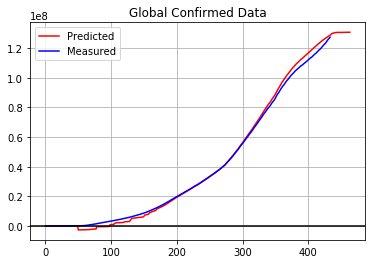

0.0029284088716899376

In [453]:
model = TransAm().to(device)
model = loadModel(model, "parameter_global_
                  confirmed_50sq_+_best_1")
dealData = DealData()
dealData.plot_and_loss(model, 0)

464 434


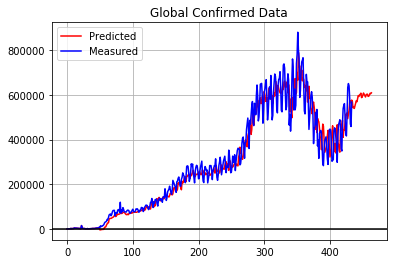

0.0632611723597266

In [407]:
model = TransAm().to(device)
model = loadModel(model)
dealData = DealData()
dealData.plot_and_loss(model, 0)

462 432


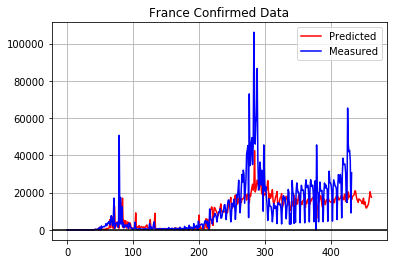

0.4328816279792166

In [362]:
model = TransAm().to(device)
model = loadModel(model)
dealData = DealData()
dealData.plot_and_loss(model, 0)

455 425


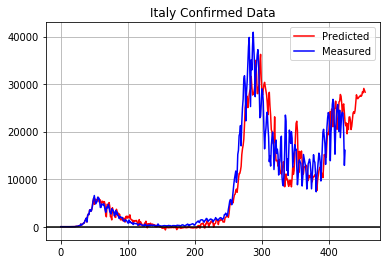

0.08769355235570907

In [358]:
model = TransAm().to(device)
model = loadModel(model)
dealData = DealData()
dealData.plot_and_loss(model, 0)

464 434


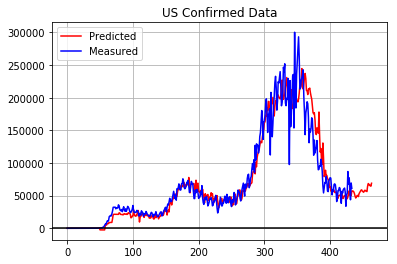

0.07861672422189664

In [350]:
model = TransAm().to(device)
model = loadModel(model)
dealData = DealData()
dealData.plot_and_loss(model, 0)

464 434


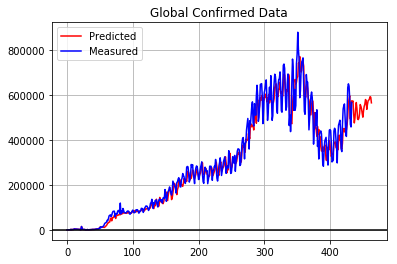

0.05538242353629758

In [341]:
model = TransAm().to(device)
model = loadModel(model)
dealData = DealData()
dealData.plot_and_loss(model, 0)

/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    27/  138 batches | lr 0.005000 | 14.23 ms | loss 8.99677 | ppl  8076.93
| epoch   1 |    54/  138 batches | lr 0.005000 | 16.22 ms | loss 0.67061 | ppl     1.96
| epoch   1 |    81/  138 batches | lr 0.005000 | 19.97 ms | loss 0.26535 | ppl     1.30
| epoch   1 |   108/  138 batches | lr 0.005000 | 13.78 ms | loss 0.26827 | ppl     1.31
| epoch   1 |   135/  138 batches | lr 0.005000 | 14.67 ms | loss 0.24306 | ppl     1.28
| epoch   2 |    27/  138 batches | lr 0.004513 | 14.64 ms | loss 1.07634 | ppl     2.93
| epoch   2 |    54/  138 batches | lr 0.004513 | 19.52 ms | loss 0.54634 | ppl     1.73
| epoch   2 |    81/  138 batches | lr 0.004513 | 18.60 ms | loss 0.26878 | ppl     1.31
| epoch   2 |   108/  138 batches | lr 0.004513 | 15.92 ms | loss 0.24719 | ppl     1.28
| epoch   2 |   135/  138 batches | lr 0.004513 | 17.83 ms | loss 0.23577 | ppl     1.27
| epoch   3 |    27/  138 batches | lr 0.004287 | 19.36 ms | loss 1.21582 | ppl     3.37
| epoch   3 |    54/ 

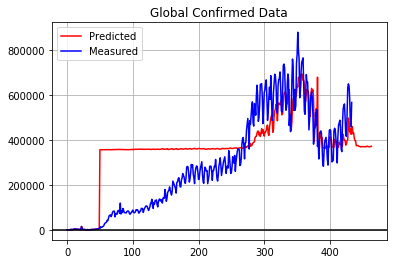

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  3.46s | valid loss 0.72554 | valid ppl     2.07
-----------------------------------------------------------------------------------------
| epoch  11 |    27/  138 batches | lr 0.002844 | 14.13 ms | loss 0.68603 | ppl     1.99
| epoch  11 |    54/  138 batches | lr 0.002844 | 13.14 ms | loss 0.37678 | ppl     1.46
| epoch  11 |    81/  138 batches | lr 0.002844 | 14.90 ms | loss 0.16917 | ppl     1.18
| epoch  11 |   108/  138 batches | lr 0.002844 | 17.65 ms | loss 0.13429 | ppl     1.14
| epoch  11 |   135/  138 batches | lr 0.002844 | 20.35 ms | loss 0.12746 | ppl     1.14
| epoch  12 |    27/  138 batches | lr 0.002702 | 14.79 ms | loss 0.60756 | ppl     1.84
| epoch  12 |    54/  138 batches | lr 0.002702 | 15.24 ms | loss 0.20389 | ppl     1.23
| epoch  12 |    81/  138 batches | lr 0.002702 | 15.16 ms | loss 0.12623 | ppl     1.13
| epoch  12 |   108/  138 batche

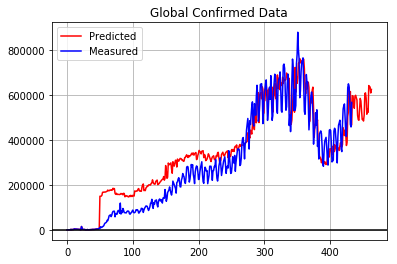

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  3.70s | valid loss 0.18383 | valid ppl     1.20
-----------------------------------------------------------------------------------------
| epoch  21 |    27/  138 batches | lr 0.001703 | 14.09 ms | loss 0.10621 | ppl     1.11
| epoch  21 |    54/  138 batches | lr 0.001703 | 15.90 ms | loss 0.14839 | ppl     1.16
| epoch  21 |    81/  138 batches | lr 0.001703 | 19.73 ms | loss 0.11654 | ppl     1.12
| epoch  21 |   108/  138 batches | lr 0.001703 | 19.96 ms | loss 0.11722 | ppl     1.12
| epoch  21 |   135/  138 batches | lr 0.001703 | 15.82 ms | loss 0.11619 | ppl     1.12
| epoch  22 |    27/  138 batches | lr 0.001618 | 13.62 ms | loss 0.10583 | ppl     1.11
| epoch  22 |    54/  138 batches | lr 0.001618 | 13.53 ms | loss 0.13748 | ppl     1.15
| epoch  22 |    81/  138 batches | lr 0.001618 | 13.38 ms | loss 0.11091 | ppl     1.12
| epoch  22 |   108/  138 batche

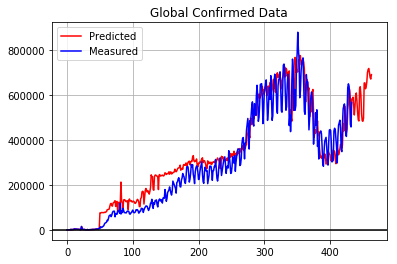

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  3.43s | valid loss 0.11383 | valid ppl     1.12
-----------------------------------------------------------------------------------------
| epoch  31 |    27/  138 batches | lr 0.001020 | 15.75 ms | loss 0.04427 | ppl     1.05
| epoch  31 |    54/  138 batches | lr 0.001020 | 16.65 ms | loss 0.13151 | ppl     1.14
| epoch  31 |    81/  138 batches | lr 0.001020 | 17.36 ms | loss 0.10946 | ppl     1.12
| epoch  31 |   108/  138 batches | lr 0.001020 | 16.47 ms | loss 0.10572 | ppl     1.11
| epoch  31 |   135/  138 batches | lr 0.001020 | 13.04 ms | loss 0.09930 | ppl     1.10
| epoch  32 |    27/  138 batches | lr 0.000969 | 14.45 ms | loss 0.03875 | ppl     1.04
| epoch  32 |    54/  138 batches | lr 0.000969 | 16.75 ms | loss 0.12732 | ppl     1.14
| epoch  32 |    81/  138 batches | lr 0.000969 | 18.03 ms | loss 0.10376 | ppl     1.11
| epoch  32 |   108/  138 batche

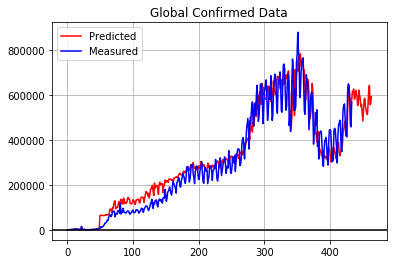

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  3.81s | valid loss 0.08159 | valid ppl     1.09
-----------------------------------------------------------------------------------------
| epoch  41 |    27/  138 batches | lr 0.000610 | 16.34 ms | loss 0.03686 | ppl     1.04
| epoch  41 |    54/  138 batches | lr 0.000610 | 15.26 ms | loss 0.12313 | ppl     1.13
| epoch  41 |    81/  138 batches | lr 0.000610 | 17.84 ms | loss 0.09893 | ppl     1.10
| epoch  41 |   108/  138 batches | lr 0.000610 | 14.18 ms | loss 0.09921 | ppl     1.10
| epoch  41 |   135/  138 batches | lr 0.000610 | 13.65 ms | loss 0.09532 | ppl     1.10
| epoch  42 |    27/  138 batches | lr 0.000580 | 13.79 ms | loss 0.03338 | ppl     1.03
| epoch  42 |    54/  138 batches | lr 0.000580 | 17.34 ms | loss 0.12169 | ppl     1.13
| epoch  42 |    81/  138 batches | lr 0.000580 | 16.96 ms | loss 0.09828 | ppl     1.10
| epoch  42 |   108/  138 batche

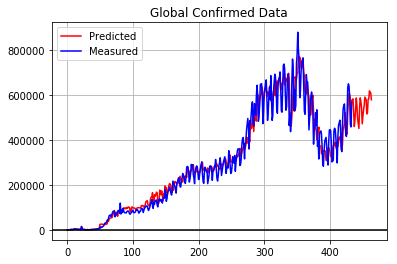

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  3.65s | valid loss 0.05820 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  51 |    27/  138 batches | lr 0.000365 | 14.35 ms | loss 0.02734 | ppl     1.03
| epoch  51 |    54/  138 batches | lr 0.000365 | 14.94 ms | loss 0.11594 | ppl     1.12
| epoch  51 |    81/  138 batches | lr 0.000365 | 15.64 ms | loss 0.09306 | ppl     1.10
| epoch  51 |   108/  138 batches | lr 0.000365 | 14.20 ms | loss 0.09470 | ppl     1.10
| epoch  51 |   135/  138 batches | lr 0.000365 | 14.16 ms | loss 0.09071 | ppl     1.09
| epoch  52 |    27/  138 batches | lr 0.000347 | 14.41 ms | loss 0.02778 | ppl     1.03
| epoch  52 |    54/  138 batches | lr 0.000347 | 13.58 ms | loss 0.11609 | ppl     1.12
| epoch  52 |    81/  138 batches | lr 0.000347 | 14.08 ms | loss 0.09187 | ppl     1.10
| epoch  52 |   108/  138 batche

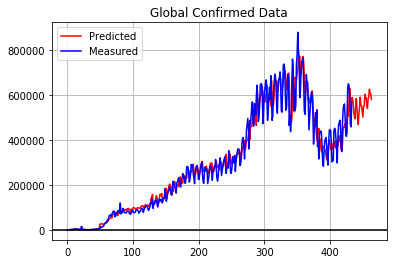

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  3.68s | valid loss 0.05662 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  61 |    27/  138 batches | lr 0.000219 | 19.73 ms | loss 0.02686 | ppl     1.03
| epoch  61 |    54/  138 batches | lr 0.000219 | 16.03 ms | loss 0.11349 | ppl     1.12
| epoch  61 |    81/  138 batches | lr 0.000219 | 14.35 ms | loss 0.08944 | ppl     1.09
| epoch  61 |   108/  138 batches | lr 0.000219 | 17.34 ms | loss 0.09111 | ppl     1.10
| epoch  61 |   135/  138 batches | lr 0.000219 | 17.88 ms | loss 0.08814 | ppl     1.09
| epoch  62 |    27/  138 batches | lr 0.000208 | 21.89 ms | loss 0.02674 | ppl     1.03
| epoch  62 |    54/  138 batches | lr 0.000208 | 16.23 ms | loss 0.11302 | ppl     1.12
| epoch  62 |    81/  138 batches | lr 0.000208 | 15.13 ms | loss 0.08804 | ppl     1.09
| epoch  62 |   108/  138 batche

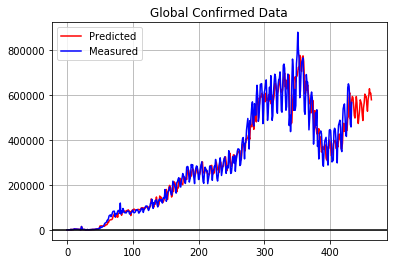

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  3.79s | valid loss 0.05560 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  71 |    27/  138 batches | lr 0.000131 | 22.53 ms | loss 0.02601 | ppl     1.03
| epoch  71 |    54/  138 batches | lr 0.000131 | 15.15 ms | loss 0.11019 | ppl     1.12
| epoch  71 |    81/  138 batches | lr 0.000131 | 15.97 ms | loss 0.08637 | ppl     1.09
| epoch  71 |   108/  138 batches | lr 0.000131 | 15.91 ms | loss 0.08852 | ppl     1.09
| epoch  71 |   135/  138 batches | lr 0.000131 | 17.21 ms | loss 0.08532 | ppl     1.09
| epoch  72 |    27/  138 batches | lr 0.000124 | 23.24 ms | loss 0.02635 | ppl     1.03
| epoch  72 |    54/  138 batches | lr 0.000124 | 15.09 ms | loss 0.11043 | ppl     1.12
| epoch  72 |    81/  138 batches | lr 0.000124 | 15.54 ms | loss 0.08577 | ppl     1.09
| epoch  72 |   108/  138 batche

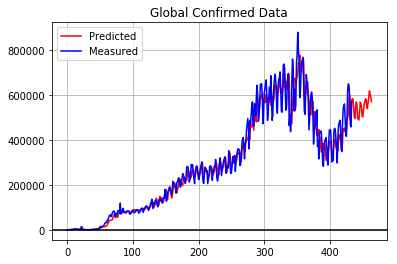

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  3.54s | valid loss 0.05513 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  81 |    27/  138 batches | lr 0.000078 | 16.41 ms | loss 0.02635 | ppl     1.03
| epoch  81 |    54/  138 batches | lr 0.000078 | 13.23 ms | loss 0.10794 | ppl     1.11
| epoch  81 |    81/  138 batches | lr 0.000078 | 13.84 ms | loss 0.08471 | ppl     1.09
| epoch  81 |   108/  138 batches | lr 0.000078 | 19.96 ms | loss 0.08656 | ppl     1.09
| epoch  81 |   135/  138 batches | lr 0.000078 | 14.43 ms | loss 0.08345 | ppl     1.09
| epoch  82 |    27/  138 batches | lr 0.000075 | 17.09 ms | loss 0.02542 | ppl     1.03
| epoch  82 |    54/  138 batches | lr 0.000075 | 17.47 ms | loss 0.10841 | ppl     1.11
| epoch  82 |    81/  138 batches | lr 0.000075 | 17.30 ms | loss 0.08443 | ppl     1.09
| epoch  82 |   108/  138 batche

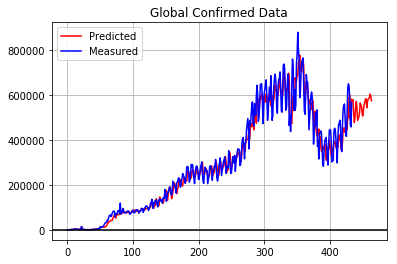

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  3.86s | valid loss 0.05559 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  91 |    27/  138 batches | lr 0.000047 | 15.07 ms | loss 0.02617 | ppl     1.03
| epoch  91 |    54/  138 batches | lr 0.000047 | 16.37 ms | loss 0.10725 | ppl     1.11
| epoch  91 |    81/  138 batches | lr 0.000047 | 15.65 ms | loss 0.08324 | ppl     1.09
| epoch  91 |   108/  138 batches | lr 0.000047 | 14.94 ms | loss 0.08540 | ppl     1.09
| epoch  91 |   135/  138 batches | lr 0.000047 | 19.91 ms | loss 0.08213 | ppl     1.09
| epoch  92 |    27/  138 batches | lr 0.000045 | 15.36 ms | loss 0.02577 | ppl     1.03
| epoch  92 |    54/  138 batches | lr 0.000045 | 16.44 ms | loss 0.10796 | ppl     1.11
| epoch  92 |    81/  138 batches | lr 0.000045 | 16.00 ms | loss 0.08355 | ppl     1.09
| epoch  92 |   108/  138 batche

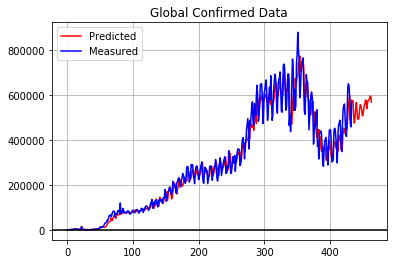

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  3.71s | valid loss 0.05538 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 101 |    27/  138 batches | lr 0.000028 | 18.35 ms | loss 0.02548 | ppl     1.03
| epoch 101 |    54/  138 batches | lr 0.000028 | 14.80 ms | loss 0.10659 | ppl     1.11
| epoch 101 |    81/  138 batches | lr 0.000028 | 13.23 ms | loss 0.08144 | ppl     1.08
| epoch 101 |   108/  138 batches | lr 0.000028 | 13.09 ms | loss 0.08373 | ppl     1.09
| epoch 101 |   135/  138 batches | lr 0.000028 | 12.91 ms | loss 0.08137 | ppl     1.08
| epoch 102 |    27/  138 batches | lr 0.000027 | 12.98 ms | loss 0.02578 | ppl     1.03
| epoch 102 |    54/  138 batches | lr 0.000027 | 19.83 ms | loss 0.10622 | ppl     1.11
| epoch 102 |    81/  138 batches | lr 0.000027 | 15.12 ms | loss 0.08153 | ppl     1.08
| epoch 102 |   108/  138 batche

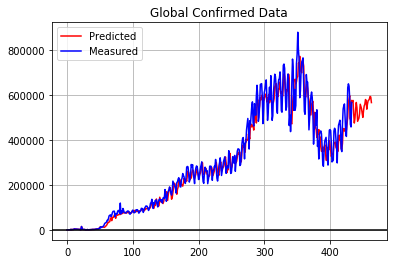

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  3.70s | valid loss 0.05523 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 111 |    27/  138 batches | lr 0.000017 | 14.17 ms | loss 0.02546 | ppl     1.03
| epoch 111 |    54/  138 batches | lr 0.000017 | 16.25 ms | loss 0.10610 | ppl     1.11
| epoch 111 |    81/  138 batches | lr 0.000017 | 18.13 ms | loss 0.08102 | ppl     1.08
| epoch 111 |   108/  138 batches | lr 0.000017 | 16.05 ms | loss 0.08279 | ppl     1.09
| epoch 111 |   135/  138 batches | lr 0.000017 | 14.31 ms | loss 0.07965 | ppl     1.08
| epoch 112 |    27/  138 batches | lr 0.000016 | 15.64 ms | loss 0.02551 | ppl     1.03
| epoch 112 |    54/  138 batches | lr 0.000016 | 15.82 ms | loss 0.10632 | ppl     1.11
| epoch 112 |    81/  138 batches | lr 0.000016 | 21.06 ms | loss 0.08062 | ppl     1.08
| epoch 112 |   108/  138 batche

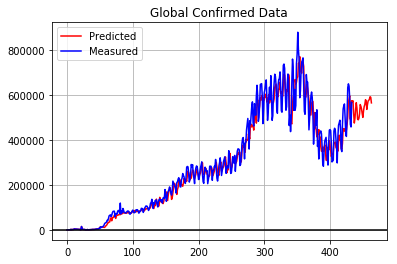

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  4.06s | valid loss 0.05517 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 121 |    27/  138 batches | lr 0.000010 | 13.71 ms | loss 0.02520 | ppl     1.03
| epoch 121 |    54/  138 batches | lr 0.000010 | 14.56 ms | loss 0.10604 | ppl     1.11
| epoch 121 |    81/  138 batches | lr 0.000010 | 18.63 ms | loss 0.08003 | ppl     1.08
| epoch 121 |   108/  138 batches | lr 0.000010 | 17.83 ms | loss 0.08212 | ppl     1.09
| epoch 121 |   135/  138 batches | lr 0.000010 | 12.37 ms | loss 0.08008 | ppl     1.08
| epoch 122 |    27/  138 batches | lr 0.000010 | 15.76 ms | loss 0.02519 | ppl     1.03
| epoch 122 |    54/  138 batches | lr 0.000010 | 13.84 ms | loss 0.10621 | ppl     1.11
| epoch 122 |    81/  138 batches | lr 0.000010 | 15.30 ms | loss 0.08016 | ppl     1.08
| epoch 122 |   108/  138 batche

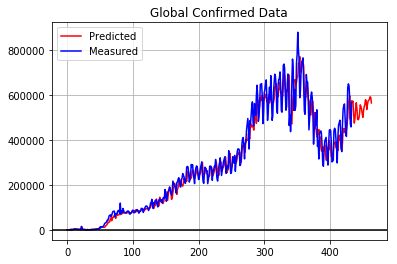

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  3.87s | valid loss 0.05517 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 131 |    27/  138 batches | lr 0.000006 | 18.08 ms | loss 0.02546 | ppl     1.03
| epoch 131 |    54/  138 batches | lr 0.000006 | 16.25 ms | loss 0.10638 | ppl     1.11
| epoch 131 |    81/  138 batches | lr 0.000006 | 14.74 ms | loss 0.08063 | ppl     1.08
| epoch 131 |   108/  138 batches | lr 0.000006 | 19.36 ms | loss 0.08153 | ppl     1.08
| epoch 131 |   135/  138 batches | lr 0.000006 | 14.66 ms | loss 0.08008 | ppl     1.08
| epoch 132 |    27/  138 batches | lr 0.000006 | 15.67 ms | loss 0.02542 | ppl     1.03
| epoch 132 |    54/  138 batches | lr 0.000006 | 16.42 ms | loss 0.10560 | ppl     1.11
| epoch 132 |    81/  138 batches | lr 0.000006 | 17.46 ms | loss 0.08063 | ppl     1.08
| epoch 132 |   108/  138 batche

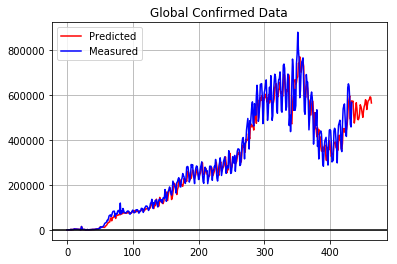

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  3.95s | valid loss 0.05521 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 141 |    27/  138 batches | lr 0.000004 | 18.36 ms | loss 0.02534 | ppl     1.03
| epoch 141 |    54/  138 batches | lr 0.000004 | 16.53 ms | loss 0.10546 | ppl     1.11
| epoch 141 |    81/  138 batches | lr 0.000004 | 15.15 ms | loss 0.07960 | ppl     1.08
| epoch 141 |   108/  138 batches | lr 0.000004 | 17.40 ms | loss 0.08170 | ppl     1.09
| epoch 141 |   135/  138 batches | lr 0.000004 | 19.09 ms | loss 0.07998 | ppl     1.08
| epoch 142 |    27/  138 batches | lr 0.000003 | 13.77 ms | loss 0.02509 | ppl     1.03
| epoch 142 |    54/  138 batches | lr 0.000003 | 14.86 ms | loss 0.10616 | ppl     1.11
| epoch 142 |    81/  138 batches | lr 0.000003 | 16.70 ms | loss 0.08003 | ppl     1.08
| epoch 142 |   108/  138 batche

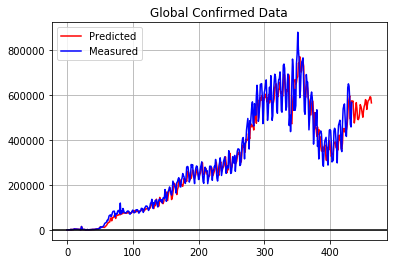

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  3.55s | valid loss 0.05528 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 151 |    27/  138 batches | lr 0.000002 | 13.84 ms | loss 0.02548 | ppl     1.03
| epoch 151 |    54/  138 batches | lr 0.000002 | 15.96 ms | loss 0.10580 | ppl     1.11
| epoch 151 |    81/  138 batches | lr 0.000002 | 14.57 ms | loss 0.08006 | ppl     1.08
| epoch 151 |   108/  138 batches | lr 0.000002 | 12.62 ms | loss 0.08163 | ppl     1.09
| epoch 151 |   135/  138 batches | lr 0.000002 | 19.50 ms | loss 0.07900 | ppl     1.08
| epoch 152 |    27/  138 batches | lr 0.000002 | 14.08 ms | loss 0.02492 | ppl     1.03
| epoch 152 |    54/  138 batches | lr 0.000002 | 16.78 ms | loss 0.10480 | ppl     1.11
| epoch 152 |    81/  138 batches | lr 0.000002 | 16.87 ms | loss 0.07949 | ppl     1.08
| epoch 152 |   108/  138 batche

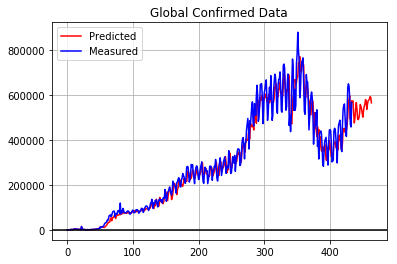

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  3.37s | valid loss 0.05534 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 161 |    27/  138 batches | lr 0.000001 | 20.21 ms | loss 0.02543 | ppl     1.03
| epoch 161 |    54/  138 batches | lr 0.000001 | 14.93 ms | loss 0.10591 | ppl     1.11
| epoch 161 |    81/  138 batches | lr 0.000001 | 13.73 ms | loss 0.08039 | ppl     1.08
| epoch 161 |   108/  138 batches | lr 0.000001 | 16.01 ms | loss 0.08224 | ppl     1.09
| epoch 161 |   135/  138 batches | lr 0.000001 | 19.46 ms | loss 0.07927 | ppl     1.08
| epoch 162 |    27/  138 batches | lr 0.000001 | 21.49 ms | loss 0.02534 | ppl     1.03
| epoch 162 |    54/  138 batches | lr 0.000001 | 15.44 ms | loss 0.10669 | ppl     1.11
| epoch 162 |    81/  138 batches | lr 0.000001 | 14.30 ms | loss 0.07966 | ppl     1.08
| epoch 162 |   108/  138 batche

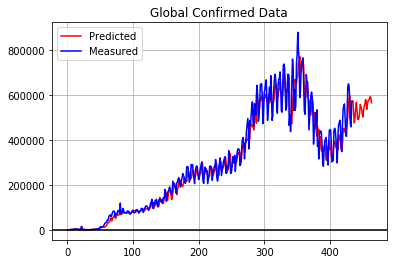

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  3.77s | valid loss 0.05536 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 171 |    27/  138 batches | lr 0.000001 | 15.75 ms | loss 0.02550 | ppl     1.03
| epoch 171 |    54/  138 batches | lr 0.000001 | 20.00 ms | loss 0.10527 | ppl     1.11
| epoch 171 |    81/  138 batches | lr 0.000001 | 14.65 ms | loss 0.07982 | ppl     1.08
| epoch 171 |   108/  138 batches | lr 0.000001 | 14.21 ms | loss 0.08167 | ppl     1.09
| epoch 171 |   135/  138 batches | lr 0.000001 | 13.92 ms | loss 0.07865 | ppl     1.08
| epoch 172 |    27/  138 batches | lr 0.000001 | 14.69 ms | loss 0.02578 | ppl     1.03
| epoch 172 |    54/  138 batches | lr 0.000001 | 19.59 ms | loss 0.10551 | ppl     1.11
| epoch 172 |    81/  138 batches | lr 0.000001 | 14.92 ms | loss 0.07911 | ppl     1.08
| epoch 172 |   108/  138 batche

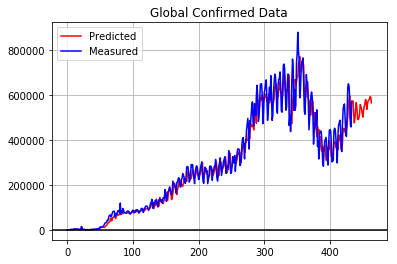

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  3.60s | valid loss 0.05536 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 181 |    27/  138 batches | lr 0.000000 | 19.29 ms | loss 0.02549 | ppl     1.03
| epoch 181 |    54/  138 batches | lr 0.000000 | 19.69 ms | loss 0.10537 | ppl     1.11
| epoch 181 |    81/  138 batches | lr 0.000000 | 15.29 ms | loss 0.08049 | ppl     1.08
| epoch 181 |   108/  138 batches | lr 0.000000 | 15.50 ms | loss 0.08211 | ppl     1.09
| epoch 181 |   135/  138 batches | lr 0.000000 | 16.97 ms | loss 0.07884 | ppl     1.08
| epoch 182 |    27/  138 batches | lr 0.000000 | 21.04 ms | loss 0.02559 | ppl     1.03
| epoch 182 |    54/  138 batches | lr 0.000000 | 19.14 ms | loss 0.10537 | ppl     1.11
| epoch 182 |    81/  138 batches | lr 0.000000 | 16.47 ms | loss 0.07975 | ppl     1.08
| epoch 182 |   108/  138 batche

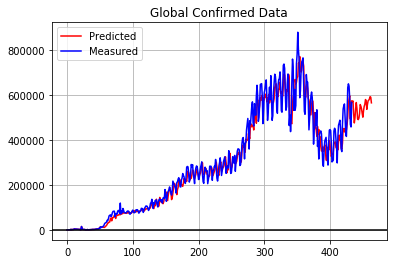

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  4.19s | valid loss 0.05538 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 191 |    27/  138 batches | lr 0.000000 | 18.02 ms | loss 0.02529 | ppl     1.03
| epoch 191 |    54/  138 batches | lr 0.000000 | 18.47 ms | loss 0.10559 | ppl     1.11
| epoch 191 |    81/  138 batches | lr 0.000000 | 15.74 ms | loss 0.07972 | ppl     1.08
| epoch 191 |   108/  138 batches | lr 0.000000 | 17.29 ms | loss 0.08142 | ppl     1.08
| epoch 191 |   135/  138 batches | lr 0.000000 | 21.60 ms | loss 0.07943 | ppl     1.08
| epoch 192 |    27/  138 batches | lr 0.000000 | 17.00 ms | loss 0.02494 | ppl     1.03
| epoch 192 |    54/  138 batches | lr 0.000000 | 14.44 ms | loss 0.10613 | ppl     1.11
| epoch 192 |    81/  138 batches | lr 0.000000 | 16.92 ms | loss 0.07863 | ppl     1.08
| epoch 192 |   108/  138 batche

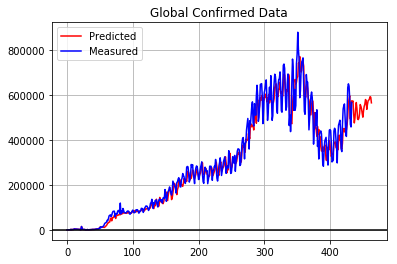

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  3.52s | valid loss 0.05538 | valid ppl     1.06
-----------------------------------------------------------------------------------------


In [336]:
50

# 

In [ ]:
global:  0.04991